# **Classification task to fine-tune personal documents**

## **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


##**Importing all libraries we need**




In [2]:
%%capture

!pip install codecarbon
!pip install mxnet
!pip install vit-keras
!pip install tensorflow-addons==0.16.1

In [3]:
import os
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker
import itertools

from tensorflow.keras.utils import load_img
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence as Sequence
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preproc_mbt2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preproc_mbt3
from tensorflow.keras.applications.vgg16 import preprocess_input as preproc_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preproc_rsn50
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
import mxnet as mx
from keras.models import load_model
from enum import Enum
from tensorflow.keras.models import Model

##**Constants values**

In [4]:
## File images path
base_path = "/content/gdrive/MyDrive/DatasetNew/"
base_path_img = "/content/gdrive/MyDrive/DatasetNew/data/"

## Data Generator values
batch_size = 16
inp_dim = (224,224)
n_channels = 3
n_classes = 10

## Image files list
imgs_list = os.listdir(base_path_img)

## Image size
input_size = (224, 224, 3)

## Training, Validation and Testing Percent
train_perc = 0.7
valid_perc = 0.1

## Epoch numbers for fine tuning
num_epochs = 10

## plotlib results number
num_results = 20


##**Switch case classes**

In [5]:
## Define different classes to create each label

img_ids = ["ic_CIE.front.", "ic_CIE.rear.", "dl_I11.front.", "dl_I11.rear.", "dl_I10.front.", "dl_I10.rear.", "ic_TES.front.", "ic_TES.rear.", "doc_NR.front.", "doc_NR.rear."]

def switch(img_id):
    for i, id in enumerate(img_ids):
        if id in img_id:
            return i
    return None

## **Data Augmentation and Preprocessing image**

In [6]:
#Define different image preprocess for each model

Models = ["MbNt3", "MbNt2", "VGG16", "RES50"]

def switch_preprocess(model, img_):
  # print(img_)
  if(model == Models[0]):
    img = preproc_mbt3(img_)
  elif(model == Models[1]):
    img = preproc_mbt2(img_)
  elif(model == Models[2]):
    img = preproc_vgg(img_)
  elif(model == Models[3]):
    img = preproc_rsn50(img_)
  return img

[[[0.44313726 0.44313726 0.40392157]
  [0.4        0.36078432 0.3137255 ]
  [0.3254902  0.30980393 0.2627451 ]
  ...
  [0.38431373 0.35686275 0.29411766]
  [0.3647059  0.37254903 0.2901961 ]
  [0.41568628 0.40784314 0.3254902 ]]

 [[0.4509804  0.47843137 0.41568628]
  [0.4117647  0.3882353  0.33333334]
  [0.3372549  0.30980393 0.28627452]
  ...
  [0.3882353  0.35686275 0.3137255 ]
  [0.38039216 0.36862746 0.30980393]
  [0.4117647  0.36078432 0.28627452]]

 [[0.41960785 0.43529412 0.38039216]
  [0.3137255  0.31764707 0.25490198]
  [0.34117648 0.32156864 0.29803923]
  ...
  [0.38039216 0.37254903 0.3254902 ]
  [0.36862746 0.3529412  0.30588236]
  [0.3882353  0.36078432 0.25882354]]

 ...

 [[0.36078432 0.33333334 0.27058825]
  [0.32156864 0.32156864 0.28235295]
  [0.4        0.3882353  0.3529412 ]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.01568628 0.01568628 0.01568628]
  [0.01960784 0.01960784 0.01960784]]

 [[0.34117648 0.33333334 0.28235295]
  [0.32156864 0.29803923 0.2509804 ]


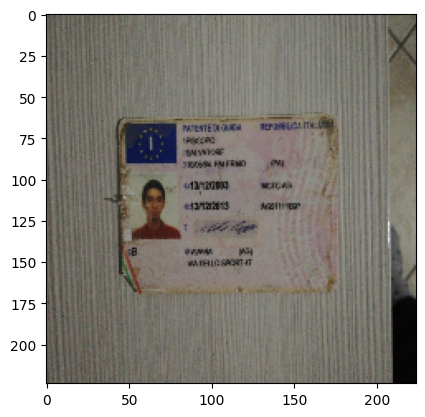

In [7]:
#Sample

image_path = os.path.join(base_path_img,"dl_I10.front.6397.jpg")
img = load_img(image_path, target_size =inp_dim)
img = img_to_array(img)

img = switch_preprocess(Models[0], img)
img /= 255.0
img = np.clip(img, 0, 1)
print(img)

plt.imshow(img)
plt.show()

In [8]:
#Augment data randomly throw rotation, brightless and lighting

def switch_aug(img_):
  temp_img = img_.copy()
  rndm_value = random.uniform(0.2, 0.6)
  rndm_type = random.randint(0, 2)
  if rndm_type == 0:
    alpha = np.random.normal(0, 100, size=(3,))
    rgb = np.dot(np.asarray([1,1,1]) * alpha, np.ones((3,3)))
    img_ = temp_img + rgb
  elif rndm_type == 1:
    aug = mx.image.BrightnessJitterAug(brightness=rndm_value)
    img_ = aug(temp_img)
  elif rndm_type == 2:
    img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

def augment_data(img_):
  img_ = switch_aug(img_)
  img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

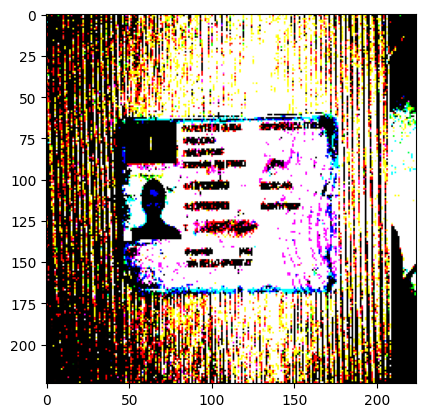

In [9]:
#Sample

image_path = os.path.join(base_path_img,"dl_I10.front.6397.jpg")
img = load_img(image_path, target_size = inp_dim)
img = img_to_array(img)

img = switch_preprocess(Models[3], img)
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.show()

## **Data Generator**

In [10]:
## Generates data for Keras

class DataGenerator(Sequence):
    def __init__(
        self, all_imgs_list, split_A, split_B, model_type, batch_size=batch_size, n_channels=n_channels,
        n_classes=n_classes, inp_dim=inp_dim, train=False, shuffle=False):

        ## Initialization of attributes
        self.list_IDs = all_imgs_list
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inp_dim = inp_dim
        self.shuffle = shuffle
        self.train = train
        self.model_type = model_type

        ## Get number of all the images contained in the directory

        self.len = len(self.list_IDs)

        ## Split into training, validation or test set
        self.list_IDs = self.list_IDs[int(self.len*split_A):int(self.len*split_B)]
        self.on_epoch_end()

    ## Denotes the number of batches per epoch

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    ## get_item generates one batch of data

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        ## Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        ## Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    ## Updates indexes after each epoch

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle or self.train:
            np.random.shuffle(self.indexes)


    ## Generates data containing batch_size samples

    def __data_generation(self, list_IDs_temp):
        ## Initialization with empty tensors
        X = np.empty((self.batch_size, *self.inp_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data: for i in batch_size fill the input and label vectors
        for i, (ID, augmented) in enumerate(list_IDs_temp):
          ## Get image
          img = load_img(ID, target_size = self.inp_dim)
          img = img_to_array(img)
          img = switch_preprocess(self.model_type, img)

          current_index_class = switch(ID)
          if self.train:
            if augmented:
                img = augment_data(img)

          ## Store images
          X[i, ] = img

          ## Store classes
          y[i] = current_index_class

        # Converts our classes in one hot encoded vector.
        y = tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, y

In [11]:
## shuffle datas
random.shuffle(imgs_list)
imgs_list = [os.path.join(base_path_img, img) for img in imgs_list]

## create empty tuple list
imgs_list_aug = []

## create dict with img_class index and all images of that class
balanced_img = {switch(i): [] for i in img_ids}
for j in imgs_list:
  h = switch(j)
  balanced_img[h].append((j, False))

#find the largest class
max_len = max([len(i) for i in balanced_img.values()])

## recreate balanced_img with same dimension
for img_class, img_list_data in balanced_img.items():
  for h in range((max_len + 1) - len(img_list_data)):
    my_list = random.sample(img_list_data,1)
    balanced_img[img_class].append((my_list[0][0], True))

## reduce balanced_img to list
for i in balanced_img.values():
  for j in i:
    imgs_list_aug.append(j)

random.shuffle(imgs_list_aug)

In [12]:
#Sample to check shuffle is ok

train_gen_number = int((len(imgs_list_aug) * train_perc))
train_data = imgs_list_aug[:train_gen_number]

valid_gen_number = int(len(imgs_list_aug) * (train_perc + valid_perc))
valid_data = imgs_list_aug[len(train_data):valid_gen_number]

test_gen_number = int(len(imgs_list_aug))
test_data = imgs_list_aug[len(train_data + valid_data):test_gen_number]

tot = [(train_data, "train_data"), (valid_data, "valid_data"), (test_data, "test_data")]
for i,name in enumerate(tot):
  ic_CIE_front = []
  ic_CIE_rear = []
  dl_I11_front = []
  dl_I11_rear = []
  dl_I10_front = []
  dl_I10_rear = []
  ic_TES_front = []
  ic_TES_rear = []
  doc_NR_front = []
  doc_NR_rear = []
  for elem in name[0]:
    path = str(elem[0])
    if img_ids[0] in path : ic_CIE_front.append(path)
    elif img_ids[1] in path : ic_CIE_rear.append(path)
    elif img_ids[2] in path : dl_I11_front.append(path)
    elif img_ids[3] in path : dl_I11_rear.append(path)
    elif img_ids[4] in path : dl_I10_front.append(path)
    elif img_ids[5] in path : dl_I10_rear.append(path)
    elif img_ids[6] in path : ic_TES_front.append(path)
    elif img_ids[7] in path : ic_TES_rear.append(path)
    elif img_ids[8] in path : doc_NR_front.append(path)
    elif img_ids[9] in path : doc_NR_rear.append(path)

  print("\n La classe ic_CIE_front ha elementi in " + str(name[1]) + ": " + str(len(ic_CIE_front)),"\n",
      "La classe ic_CIE_rear ha elementi in " + str(name[1]) + ": " + str(len(ic_CIE_rear)),"\n",
      "La classe dl_I11_front ha elementi in " + str(name[1]) + ": " + str(len(dl_I11_front)),"\n",
      "La classe dl_I11_rear ha elementi in " + str(name[1]) + ": " + str(len(dl_I11_rear)),"\n",
      "La classe dl_I10_front ha elementi in " + str(name[1]) + ": " + str(len(dl_I10_front)),"\n",
      "La classe dl_I10_rear ha elementi in " + str(name[1]) + ": " + str(len(dl_I10_rear)),"\n",
      "La classe ic_TES_front ha elementi in " + str(name[1]) + ": " + str(len(ic_TES_front)),"\n",
      "La classe ic_TES_rear ha elementi in " + str(name[1]) + ": " + str(len(ic_TES_rear)),"\n",
      "La classe doc_NR_front ha elementi in " + str(name[1]) + ": " + str(len(doc_NR_front)),"\n",
      "La classe doc_NR_rear ha elementi in " + str(name[1]) + ": " + str(len(doc_NR_rear)),"\n")


 La classe ic_CIE_front ha elementi in train_data: 66 
 La classe ic_CIE_rear ha elementi in train_data: 62 
 La classe dl_I11_front ha elementi in train_data: 66 
 La classe dl_I11_rear ha elementi in train_data: 73 
 La classe dl_I10_front ha elementi in train_data: 65 
 La classe dl_I10_rear ha elementi in train_data: 62 
 La classe ic_TES_front ha elementi in train_data: 70 
 La classe ic_TES_rear ha elementi in train_data: 61 
 La classe doc_NR_front ha elementi in train_data: 71 
 La classe doc_NR_rear ha elementi in train_data: 76 


 La classe ic_CIE_front ha elementi in valid_data: 13 
 La classe ic_CIE_rear ha elementi in valid_data: 15 
 La classe dl_I11_front ha elementi in valid_data: 12 
 La classe dl_I11_rear ha elementi in valid_data: 6 
 La classe dl_I10_front ha elementi in valid_data: 9 
 La classe dl_I10_rear ha elementi in valid_data: 10 
 La classe ic_TES_front ha elementi in valid_data: 4 
 La classe ic_TES_rear ha elementi in valid_data: 10 
 La classe doc_NR_f

In [13]:
## Create generator for each model type

train_generator_mbt3 = DataGenerator(imgs_list_aug, 0, train_perc, train=True, shuffle=True, model_type = Models[0])
valid_generator_mbt3 = DataGenerator(imgs_list_aug, train_perc, train_perc + valid_perc, model_type = Models[0])
test_generator_mbt3  = DataGenerator(imgs_list_aug, train_perc + valid_perc, 1, model_type = Models[0])

train_generator_mbt2 = DataGenerator(imgs_list_aug, 0, train_perc, train=True, shuffle=True, model_type = Models[1])
valid_generator_mbt2 = DataGenerator(imgs_list_aug, train_perc, train_perc + valid_perc, model_type = Models[1])
test_generator_mbt2  = DataGenerator(imgs_list_aug, train_perc + valid_perc, 1, model_type = Models[1])

train_generator_vgg = DataGenerator(imgs_list_aug, 0, train_perc, train=True, shuffle=True, model_type = Models[2])
valid_generator_vgg = DataGenerator(imgs_list_aug, train_perc, train_perc + valid_perc, model_type = Models[2])
test_generator_vgg  = DataGenerator(imgs_list_aug, train_perc + valid_perc, 1, model_type = Models[2])

train_generator_rsn50 = DataGenerator(imgs_list_aug, 0, train_perc, train=True, shuffle=True, model_type = Models[3])
valid_generator_rsn50 = DataGenerator(imgs_list_aug, train_perc, train_perc + valid_perc, model_type = Models[3])
test_generator_rsn50  = DataGenerator(imgs_list_aug, train_perc + valid_perc, 1, model_type = Models[3])

In [14]:
#Print generator values

print("Numero di immagini nel generator di addestramento:", len(train_generator_mbt3) * train_generator_mbt3.batch_size)
print("Numero di immagini nel generator di validazione:", len(valid_generator_mbt3) * valid_generator_mbt3.batch_size)
print("Numero di immagini nel generator di test:", len(test_generator_mbt3) * test_generator_mbt3.batch_size)

print("\nNumero di immagini nel generator di addestramento:", len(train_generator_mbt2) * train_generator_mbt2.batch_size)
print("Numero di immagini nel generator di validazione:", len(valid_generator_mbt2) * valid_generator_mbt2.batch_size)
print("Numero di immagini nel generator di test:", len(test_generator_mbt2) * test_generator_mbt2.batch_size)

print("\nNumero di immagini nel generator di addestramento:", len(train_generator_vgg) * train_generator_vgg.batch_size)
print("Numero di immagini nel generator di validazione:", len(valid_generator_vgg) * valid_generator_vgg.batch_size)
print("Numero di immagini nel generator di test:", len(test_generator_vgg) * test_generator_vgg.batch_size)

print("\nNumero di immagini nel generator di addestramento:", len(train_generator_rsn50) * train_generator_rsn50.batch_size)
print("Numero di immagini nel generator di validazione:", len(valid_generator_rsn50) * valid_generator_rsn50.batch_size)
print("Numero di immagini nel generator di test:", len(test_generator_rsn50) * test_generator_rsn50.batch_size)

Numero di immagini nel generator di addestramento: 672
Numero di immagini nel generator di validazione: 80
Numero di immagini nel generator di test: 192

Numero di immagini nel generator di addestramento: 672
Numero di immagini nel generator di validazione: 80
Numero di immagini nel generator di test: 192

Numero di immagini nel generator di addestramento: 672
Numero di immagini nel generator di validazione: 80
Numero di immagini nel generator di test: 192

Numero di immagini nel generator di addestramento: 672
Numero di immagini nel generator di validazione: 80
Numero di immagini nel generator di test: 192


## **Creating model's grid search**

In [15]:
# Selected and import some models

test_model = {"MbNT3":MobileNetV3Large(input_shape=(input_size[0], input_size[1], input_size[2]), include_top=True, weights='imagenet'),
              "MbNT2":MobileNetV2(input_shape=(input_size[0], input_size[1], input_size[2]), include_top=True, weights='imagenet'),
              "VGG16":VGG16(input_shape=(input_size[0], input_size[1], input_size[2]), include_top=True, weights='imagenet'),
              "RESNET50":tf.keras.applications.resnet50.ResNet50(input_shape =(input_size[0], input_size[1], input_size[2]), include_top=True,weights='imagenet')}

102967424/102967424 [==============================] - 5s 0us/step


In [16]:
print(test_model)

{'MbNT3': <keras.engine.functional.Functional object at 0x7dbfb00b5210>, 'MbNT2': <keras.engine.functional.Functional object at 0x7dbfa0210130>, 'VGG16': <keras.engine.functional.Functional object at 0x7dbfa00c65c0>, 'RESNET50': <keras.engine.functional.Functional object at 0x7dbf2824b160>}


In [17]:
test_model["VGG16"].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Function to freeze model, except last four layers

def gen_models(modelInput, key):
  for layer in modelInput.layers:
      layer.trainable = False
  if key == "MbNT3":
    new_model = modelInput.layers[-2].output
    fc1 = tf.keras.layers.Dense(4096, activation='relu', name = "fc1")(new_model)
    fc2 = tf.keras.layers.Dense(2048, activation='relu', name = "fc2")(fc1)
    fc3 = tf.keras.layers.Dense(1024, activation='relu', name = "fc3")(fc2)
    fc4 = tf.keras.layers.Dense(512, activation='relu', name = "fc4")(fc3)
    softmax = tf.keras.layers.Dense(n_classes, activation='softmax', name = "softmax")(fc4)
    model = tf.keras.models.Model(inputs=modelInput.input, outputs=softmax)
  elif key == "MbNT2":
    new_model = modelInput.layers[-2].output
    fc1 = tf.keras.layers.Dense(4096, activation='relu', name = "fc1")(new_model)
    fc2 = tf.keras.layers.Dense(2048, activation='relu', name = "fc2")(fc1)
    fc3 = tf.keras.layers.Dense(1024, activation='relu', name = "fc3")(fc2)
    fc4 = tf.keras.layers.Dense(512, activation='relu', name = "fc4")(fc3)
    softmax = tf.keras.layers.Dense(n_classes, activation='softmax', name = "softmax")(fc4)
    model = tf.keras.models.Model(inputs=modelInput.input, outputs=softmax)
  elif key == "VGG16":
    new_model = modelInput.layers[-3].output
    fc1_bis = tf.keras.layers.Dense(2048, activation='relu', name = "fc1_bis")(new_model)
    fc2 = tf.keras.layers.Dense(1024, activation='relu', name = "fc2")(fc1_bis)
    fc3 = tf.keras.layers.Dense(512, activation='relu', name = "fc3")(fc2)
    softmax = tf.keras.layers.Dense(n_classes, activation='softmax', name = "softmax")(fc3)
    model = tf.keras.models.Model(inputs=modelInput.input, outputs=softmax)
  elif key == "RESNET50":
    new_model = modelInput.layers[-2].output
    fc1 = tf.keras.layers.Dense(4096, activation='relu', name = "fc1")(new_model)
    fc2 = tf.keras.layers.Dense(2048, activation='relu', name = "fc2")(fc1)
    fc3 = tf.keras.layers.Dense(1024, activation='relu', name = "fc3")(fc2)
    fc4 = tf.keras.layers.Dense(512, activation='relu', name = "fc4")(fc3)
    softmax = tf.keras.layers.Dense(n_classes, activation='softmax', name = "softmax")(fc4)
    model = tf.keras.models.Model(inputs=modelInput.input, outputs=softmax)
  return model


In [19]:
# Create our grid search with different fine tuned models

grid_models = {}

for key,curr_model in test_model.items():
  grid_models[key]=gen_models(curr_model, key)


print(list(grid_models.values())[0])

In [20]:
grid_models["MbNT3"].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
# Initialize dictionaries to find best values

best_accuracies_model = {}
best_val_accuracies_model = {}
less_emissions_model = {}
less_losses_model = {}
less_val_losses_model = {}

# Start train each model for a few epochs and save values

for key, model in grid_models.items():
  es_grid_search = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, ema_momentum=0.9))
  ## initialize carbon tracker
  tracker = EmissionsTracker()
  tracker.start()
  if key == "MbNT3":
    history = model.fit(train_generator_mbt3, validation_data=valid_generator_mbt3,
                    epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[es_grid_search])
  elif key == "MbNT2":
    history = model.fit(train_generator_mbt2, validation_data=valid_generator_mbt2,
                    epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[es_grid_search])
  elif key == "VGG16":
    history = model.fit(train_generator_vgg, validation_data=valid_generator_vgg,
                    epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[es_grid_search])
  elif key == "RESNET50":
    history = model.fit(train_generator_rsn50, validation_data=valid_generator_rsn50,
                    epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[es_grid_search])
  emissions: float = tracker.stop()
  best_accuracies_model[key] = history.history["accuracy"]
  best_val_accuracies_model[key] = history.history["val_accuracy"]
  less_emissions_model[key] = emissions
  less_losses_model[key] = history.history["loss"]
  less_val_losses_model[key] = history.history["val_loss"]

[codecarbon INFO @ 16:10:38] [setup] RAM Tracking...
[codecarbon INFO @ 16:10:38] [setup] GPU Tracking...
[codecarbon INFO @ 16:10:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:10:38] [setup] CPU Tracking...
[codecarbon WARNING @ 16:10:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:10:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:10:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:10:40] >>> Tracker's metadata:
[codecarbon INFO @ 16:10:40]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 16:10:40]   Python version: 3.10.12
[codecarbon INFO @ 16:10:40]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 16:10:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 16:10:40]   CPU count: 2
[codecarbon INFO @ 16:10:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:10:40]   GPU

Epoch 1/10


[codecarbon INFO @ 16:10:55] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:10:55] Energy consumed for all GPUs : 0.000121 kWh. Total GPU Power : 28.886 W
[codecarbon INFO @ 16:10:55] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:10:55] 0.000318 kWh of electricity used since the beginning.


 7/42 [====>.........................] - ETA: 26s - loss: 2.3694 - accuracy: 0.1696

[codecarbon INFO @ 16:11:10] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:11:10] Energy consumed for all GPUs : 0.000242 kWh. Total GPU Power : 29.083000000000002 W
[codecarbon INFO @ 16:11:10] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:11:10] 0.000636 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 18s - loss: 2.2953 - accuracy: 0.1733

[codecarbon INFO @ 16:11:25] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:11:25] Energy consumed for all GPUs : 0.000363 kWh. Total GPU Power : 29.182000000000002 W
[codecarbon INFO @ 16:11:25] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:11:25] 0.000955 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 2.2313 - accuracy: 0.2094

[codecarbon INFO @ 16:11:40] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:11:40] Energy consumed for all GPUs : 0.000485 kWh. Total GPU Power : 29.379 W
[codecarbon INFO @ 16:11:40] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:11:40] 0.001273 kWh of electricity used since the beginning.


42/42 [==============================] - 60s 1s/step - loss: 2.2229 - accuracy: 0.2128 - val_loss: 2.0716 - val_accuracy: 0.4500
Epoch 2/10
 7/42 [====>.........................] - ETA: 26s - loss: 2.0179 - accuracy: 0.4286

[codecarbon INFO @ 16:11:55] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:11:55] Energy consumed for all GPUs : 0.000608 kWh. Total GPU Power : 29.577 W
[codecarbon INFO @ 16:11:55] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:11:55] 0.001593 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 12s - loss: 2.0592 - accuracy: 0.4183

[codecarbon INFO @ 16:12:10] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:12:10] Energy consumed for all GPUs : 0.000732 kWh. Total GPU Power : 29.676000000000002 W
[codecarbon INFO @ 16:12:10] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:12:10] 0.001914 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.9940 - accuracy: 0.4554

[codecarbon INFO @ 16:12:25] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:12:25] Energy consumed for all GPUs : 0.000857 kWh. Total GPU Power : 29.972 W
[codecarbon INFO @ 16:12:25] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:12:25] 0.002236 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 942ms/step - loss: 1.9940 - accuracy: 0.4554 - val_loss: 1.8277 - val_accuracy: 0.5625
Epoch 3/10
10/42 [======>.......................] - ETA: 34s - loss: 1.7964 - accuracy: 0.6250

[codecarbon INFO @ 16:12:40] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:12:40] Energy consumed for all GPUs : 0.000982 kWh. Total GPU Power : 29.972 W
[codecarbon INFO @ 16:12:40] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:12:40] 0.002557 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 13s - loss: 1.7288 - accuracy: 0.6696

[codecarbon INFO @ 16:12:55] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:12:55] Energy consumed for all GPUs : 0.001108 kWh. Total GPU Power : 30.367 W
[codecarbon INFO @ 16:12:55] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:12:55] 0.002880 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.6727 - accuracy: 0.7009

[codecarbon INFO @ 16:13:10] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:13:10] Energy consumed for all GPUs : 0.001234 kWh. Total GPU Power : 30.268 W
[codecarbon INFO @ 16:13:10] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:13:10] 0.003203 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 1.6727 - accuracy: 0.7009 - val_loss: 1.6093 - val_accuracy: 0.6375
Epoch 4/10
15/42 [=========>....................] - ETA: 23s - loss: 1.5437 - accuracy: 0.7458

[codecarbon INFO @ 16:13:25] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:13:25] Energy consumed for all GPUs : 0.001361 kWh. Total GPU Power : 30.466 W
[codecarbon INFO @ 16:13:25] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:13:25] 0.003526 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 1.4553 - accuracy: 0.7765

[codecarbon INFO @ 16:13:40] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:13:40] Energy consumed for all GPUs : 0.001488 kWh. Total GPU Power : 30.564 W
[codecarbon INFO @ 16:13:40] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:13:40] 0.003850 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 900ms/step - loss: 1.4295 - accuracy: 0.7857 - val_loss: 1.3631 - val_accuracy: 0.7250
Epoch 5/10
 5/42 [==>...........................] - ETA: 39s - loss: 1.1843 - accuracy: 0.8875

[codecarbon INFO @ 16:13:55] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:13:55] Energy consumed for all GPUs : 0.001616 kWh. Total GPU Power : 30.762 W
[codecarbon INFO @ 16:13:55] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:13:55] 0.004175 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 16s - loss: 1.2271 - accuracy: 0.8370

[codecarbon INFO @ 16:14:10] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:14:10] Energy consumed for all GPUs : 0.001744 kWh. Total GPU Power : 30.861000000000004 W
[codecarbon INFO @ 16:14:10] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:10] 0.004501 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 1.3167 - accuracy: 0.7984

[codecarbon INFO @ 16:14:25] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:14:25] Energy consumed for all GPUs : 0.001873 kWh. Total GPU Power : 30.959 W
[codecarbon INFO @ 16:14:25] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:25] 0.004827 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 941ms/step - loss: 1.3063 - accuracy: 0.8021 - val_loss: 1.1993 - val_accuracy: 0.7125
Epoch 6/10
12/42 [=======>......................] - ETA: 26s - loss: 1.0961 - accuracy: 0.8646

[codecarbon INFO @ 16:14:40] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:14:40] Energy consumed for all GPUs : 0.002003 kWh. Total GPU Power : 31.157 W
[codecarbon INFO @ 16:14:40] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:40] 0.005153 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 11s - loss: 1.0615 - accuracy: 0.8534

[codecarbon INFO @ 16:14:55] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:14:55] Energy consumed for all GPUs : 0.002133 kWh. Total GPU Power : 31.256 W
[codecarbon INFO @ 16:14:55] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:55] 0.005480 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 962ms/step - loss: 1.0318 - accuracy: 0.8542 - val_loss: 1.0161 - val_accuracy: 0.7750


[codecarbon INFO @ 16:15:10] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:15:10] Energy consumed for all GPUs : 0.002262 kWh. Total GPU Power : 31.058 W
[codecarbon INFO @ 16:15:10] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:15:10] 0.005806 kWh of electricity used since the beginning.


Epoch 7/10
17/42 [===========>..................] - ETA: 21s - loss: 0.9007 - accuracy: 0.8971

[codecarbon INFO @ 16:15:25] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:15:25] Energy consumed for all GPUs : 0.002393 kWh. Total GPU Power : 31.256 W
[codecarbon INFO @ 16:15:25] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:15:25] 0.006133 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 4s - loss: 0.8782 - accuracy: 0.8802

[codecarbon INFO @ 16:15:40] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:15:40] Energy consumed for all GPUs : 0.002523 kWh. Total GPU Power : 31.354 W
[codecarbon INFO @ 16:15:40] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:15:40] 0.006461 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 935ms/step - loss: 0.8549 - accuracy: 0.8869 - val_loss: 0.9032 - val_accuracy: 0.7875
Epoch 8/10
 8/42 [====>.........................] - ETA: 23s - loss: 0.6845 - accuracy: 0.9297

[codecarbon INFO @ 16:15:55] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:15:55] Energy consumed for all GPUs : 0.002654 kWh. Total GPU Power : 31.435000000000006 W
[codecarbon INFO @ 16:15:55] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:15:55] 0.006789 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 12s - loss: 0.7606 - accuracy: 0.8966

[codecarbon INFO @ 16:16:10] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:16:10] Energy consumed for all GPUs : 0.002785 kWh. Total GPU Power : 31.534 W
[codecarbon INFO @ 16:16:10] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:16:10] 0.007117 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.8854

[codecarbon INFO @ 16:16:25] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:16:25] Energy consumed for all GPUs : 0.002917 kWh. Total GPU Power : 31.633000000000003 W
[codecarbon INFO @ 16:16:25] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:16:25] 0.007445 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 942ms/step - loss: 0.7734 - accuracy: 0.8854 - val_loss: 0.7923 - val_accuracy: 0.8375
Epoch 9/10
12/42 [=======>......................] - ETA: 24s - loss: 0.6937 - accuracy: 0.8906

[codecarbon INFO @ 16:16:40] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:16:40] Energy consumed for all GPUs : 0.003049 kWh. Total GPU Power : 31.731 W
[codecarbon INFO @ 16:16:40] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:16:40] 0.007774 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 9s - loss: 0.8412 - accuracy: 0.8729 

[codecarbon INFO @ 16:16:55] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:16:55] Energy consumed for all GPUs : 0.003182 kWh. Total GPU Power : 31.830000000000005 W
[codecarbon INFO @ 16:16:55] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:16:55] 0.008104 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 934ms/step - loss: 0.8012 - accuracy: 0.8720 - val_loss: 0.7092 - val_accuracy: 0.8625
Epoch 10/10


[codecarbon INFO @ 16:17:10] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:17:10] Energy consumed for all GPUs : 0.003314 kWh. Total GPU Power : 31.830000000000005 W
[codecarbon INFO @ 16:17:10] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:17:10] 0.008433 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 20s - loss: 0.6370 - accuracy: 0.8924

[codecarbon INFO @ 16:17:25] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:17:25] Energy consumed for all GPUs : 0.003447 kWh. Total GPU Power : 31.929000000000006 W
[codecarbon INFO @ 16:17:25] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:17:25] 0.008763 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.5806 - accuracy: 0.9184

[codecarbon INFO @ 16:17:40] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:17:40] Energy consumed for all GPUs : 0.003581 kWh. Total GPU Power : 32.027 W
[codecarbon INFO @ 16:17:40] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:17:40] 0.009093 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 910ms/step - loss: 0.5911 - accuracy: 0.9048 - val_loss: 0.6205 - val_accuracy: 0.8875


[codecarbon INFO @ 16:17:48] Energy consumed for RAM : 0.000564 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:17:48] Energy consumed for all GPUs : 0.003649 kWh. Total GPU Power : 32.027 W
[codecarbon INFO @ 16:17:48] Energy consumed for all CPUs : 0.005049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:17:48] 0.009262 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:17:48] [setup] RAM Tracking...
[codecarbon INFO @ 16:17:48] [setup] GPU Tracking...
[codecarbon INFO @ 16:17:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:17:48] [setup] CPU Tracking...
[codecarbon WARNING @ 16:17:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:17:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:17:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:17:50] >>> Tracker's metadata:
[codecarbon INFO @ 16:

Epoch 1/10
13/42 [========>.....................] - ETA: 21s - loss: 2.2704 - accuracy: 0.1731

[codecarbon INFO @ 16:18:05] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:18:05] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 32.027 W
[codecarbon INFO @ 16:18:05] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:18:05] 0.000331 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 8s - loss: 2.2494 - accuracy: 0.2117

[codecarbon INFO @ 16:18:20] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:18:20] Energy consumed for all GPUs : 0.000267 kWh. Total GPU Power : 32.027 W
[codecarbon INFO @ 16:18:20] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:18:20] 0.000661 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 948ms/step - loss: 2.2345 - accuracy: 0.2292 - val_loss: 2.1805 - val_accuracy: 0.3000
Epoch 2/10


[codecarbon INFO @ 16:18:35] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:18:35] Energy consumed for all GPUs : 0.000400 kWh. Total GPU Power : 32.027 W
[codecarbon INFO @ 16:18:35] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:18:35] 0.000991 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 20s - loss: 2.1586 - accuracy: 0.3368

[codecarbon INFO @ 16:18:50] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:18:50] Energy consumed for all GPUs : 0.000534 kWh. Total GPU Power : 32.126000000000005 W
[codecarbon INFO @ 16:18:50] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:18:50] 0.001321 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 4s - loss: 2.1245 - accuracy: 0.3733

[codecarbon INFO @ 16:19:05] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:19:05] Energy consumed for all GPUs : 0.000668 kWh. Total GPU Power : 32.225 W
[codecarbon INFO @ 16:19:05] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:19:05] 0.001652 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 898ms/step - loss: 2.1169 - accuracy: 0.3869 - val_loss: 2.0868 - val_accuracy: 0.3875
Epoch 3/10
 6/42 [===>..........................] - ETA: 26s - loss: 2.0337 - accuracy: 0.4792

[codecarbon INFO @ 16:19:20] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:19:20] Energy consumed for all GPUs : 0.000881 kWh. Total GPU Power : 51.155 W
[codecarbon INFO @ 16:19:20] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:19:20] 0.002062 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 15s - loss: 2.0183 - accuracy: 0.5190

[codecarbon INFO @ 16:19:35] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:19:35] Energy consumed for all GPUs : 0.001016 kWh. Total GPU Power : 32.32300000000001 W
[codecarbon INFO @ 16:19:35] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:19:35] 0.002394 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.5476

[codecarbon INFO @ 16:19:50] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:19:50] Energy consumed for all GPUs : 0.001150 kWh. Total GPU Power : 32.32300000000001 W
[codecarbon INFO @ 16:19:50] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:19:50] 0.002725 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 901ms/step - loss: 1.9954 - accuracy: 0.5476 - val_loss: 1.9978 - val_accuracy: 0.4500
Epoch 4/10
12/42 [=======>......................] - ETA: 27s - loss: 1.9525 - accuracy: 0.5208

[codecarbon INFO @ 16:20:05] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:20:05] Energy consumed for all GPUs : 0.001285 kWh. Total GPU Power : 32.422000000000004 W
[codecarbon INFO @ 16:20:05] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:20:05] 0.003057 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 1.9003 - accuracy: 0.5685 

[codecarbon INFO @ 16:20:20] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:20:20] Energy consumed for all GPUs : 0.001420 kWh. Total GPU Power : 32.422000000000004 W
[codecarbon INFO @ 16:20:20] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:20:20] 0.003389 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 927ms/step - loss: 1.8796 - accuracy: 0.5804 - val_loss: 1.8912 - val_accuracy: 0.5125
Epoch 5/10
 3/42 [=>............................] - ETA: 29s - loss: 1.9014 - accuracy: 0.4792

[codecarbon INFO @ 16:20:35] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:20:35] Energy consumed for all GPUs : 0.001555 kWh. Total GPU Power : 32.521 W
[codecarbon INFO @ 16:20:35] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:20:35] 0.003721 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 17s - loss: 1.8300 - accuracy: 0.6250

[codecarbon INFO @ 16:20:50] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:20:50] Energy consumed for all GPUs : 0.001691 kWh. Total GPU Power : 32.62 W
[codecarbon INFO @ 16:20:50] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:20:50] 0.004053 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 2s - loss: 1.7750 - accuracy: 0.6522

[codecarbon INFO @ 16:21:05] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:21:05] Energy consumed for all GPUs : 0.001827 kWh. Total GPU Power : 32.521 W
[codecarbon INFO @ 16:21:05] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:05] 0.004386 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 933ms/step - loss: 1.7784 - accuracy: 0.6443 - val_loss: 1.7926 - val_accuracy: 0.5375
Epoch 6/10
 7/42 [====>.........................] - ETA: 30s - loss: 1.6731 - accuracy: 0.7054

[codecarbon INFO @ 16:21:20] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:21:20] Energy consumed for all GPUs : 0.001962 kWh. Total GPU Power : 32.62 W
[codecarbon INFO @ 16:21:20] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:20] 0.004719 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 14s - loss: 1.6958 - accuracy: 0.6375

[codecarbon INFO @ 16:21:35] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:21:35] Energy consumed for all GPUs : 0.002098 kWh. Total GPU Power : 32.62 W
[codecarbon INFO @ 16:21:35] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:35] 0.005051 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.6744 - accuracy: 0.6548

[codecarbon INFO @ 16:21:50] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:21:50] Energy consumed for all GPUs : 0.002234 kWh. Total GPU Power : 32.62 W
[codecarbon INFO @ 16:21:50] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:50] 0.005384 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 940ms/step - loss: 1.6744 - accuracy: 0.6548 - val_loss: 1.6933 - val_accuracy: 0.6125
Epoch 7/10
15/42 [=========>....................] - ETA: 22s - loss: 1.5929 - accuracy: 0.7125

[codecarbon INFO @ 16:22:05] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:22:05] Energy consumed for all GPUs : 0.002446 kWh. Total GPU Power : 50.92800000000001 W
[codecarbon INFO @ 16:22:05] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:22:05] 0.005793 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 1.5721 - accuracy: 0.7148

[codecarbon INFO @ 16:22:20] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:22:20] Energy consumed for all GPUs : 0.002582 kWh. Total GPU Power : 32.718 W
[codecarbon INFO @ 16:22:20] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:22:20] 0.006125 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 937ms/step - loss: 1.5678 - accuracy: 0.7158 - val_loss: 1.5805 - val_accuracy: 0.6750
Epoch 8/10
 3/42 [=>............................] - ETA: 29s - loss: 1.4571 - accuracy: 0.7292

[codecarbon INFO @ 16:22:35] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:22:35] Energy consumed for all GPUs : 0.002719 kWh. Total GPU Power : 32.817 W
[codecarbon INFO @ 16:22:35] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:22:35] 0.006459 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 14s - loss: 1.4321 - accuracy: 0.7554

[codecarbon INFO @ 16:22:50] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:22:50] Energy consumed for all GPUs : 0.002877 kWh. Total GPU Power : 37.905 W
[codecarbon INFO @ 16:22:50] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:22:50] 0.006814 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 1.4240 - accuracy: 0.7484

[codecarbon INFO @ 16:23:05] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:23:05] Energy consumed for all GPUs : 0.003013 kWh. Total GPU Power : 32.817 W
[codecarbon INFO @ 16:23:05] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:05] 0.007148 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 904ms/step - loss: 1.4259 - accuracy: 0.7440 - val_loss: 1.4716 - val_accuracy: 0.6750
Epoch 9/10
11/42 [======>.......................] - ETA: 26s - loss: 1.4237 - accuracy: 0.7386

[codecarbon INFO @ 16:23:20] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:23:20] Energy consumed for all GPUs : 0.003150 kWh. Total GPU Power : 32.91600000000001 W
[codecarbon INFO @ 16:23:20] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:20] 0.007482 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 10s - loss: 1.3667 - accuracy: 0.7437

[codecarbon INFO @ 16:23:35] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:23:35] Energy consumed for all GPUs : 0.003287 kWh. Total GPU Power : 32.91600000000001 W
[codecarbon INFO @ 16:23:35] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:35] 0.007816 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 929ms/step - loss: 1.3480 - accuracy: 0.7604 - val_loss: 1.3912 - val_accuracy: 0.6500
Epoch 10/10
 1/42 [..............................] - ETA: 25s - loss: 1.1249 - accuracy: 0.8125

[codecarbon INFO @ 16:23:50] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:23:50] Energy consumed for all GPUs : 0.003424 kWh. Total GPU Power : 32.91600000000001 W
[codecarbon INFO @ 16:23:50] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:50] 0.008150 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 17s - loss: 1.2444 - accuracy: 0.7750

[codecarbon INFO @ 16:24:05] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:24:05] Energy consumed for all GPUs : 0.003563 kWh. Total GPU Power : 33.212 W
[codecarbon INFO @ 16:24:05] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:05] 0.008484 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 1.2507 - accuracy: 0.7720

[codecarbon INFO @ 16:24:20] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:24:20] Energy consumed for all GPUs : 0.003700 kWh. Total GPU Power : 32.91600000000001 W
[codecarbon INFO @ 16:24:20] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:20] 0.008819 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 940ms/step - loss: 1.2391 - accuracy: 0.7753 - val_loss: 1.2707 - val_accuracy: 0.7250


[codecarbon INFO @ 16:24:28] Energy consumed for RAM : 0.000525 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:24:28] Energy consumed for all GPUs : 0.003773 kWh. Total GPU Power : 32.91600000000001 W
[codecarbon INFO @ 16:24:28] Energy consumed for all CPUs : 0.004699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:28] 0.008997 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:28] [setup] RAM Tracking...
[codecarbon INFO @ 16:24:28] [setup] GPU Tracking...
[codecarbon INFO @ 16:24:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:24:28] [setup] CPU Tracking...
[codecarbon WARNING @ 16:24:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:24:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:24:30] >>> Tracker's metadata:
[codecarbon

Epoch 1/10
12/42 [=======>......................] - ETA: 23s - loss: 2.4242 - accuracy: 0.2708

[codecarbon INFO @ 16:24:45] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:24:45] Energy consumed for all GPUs : 0.000267 kWh. Total GPU Power : 64.123 W
[codecarbon INFO @ 16:24:45] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:45] 0.000464 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 8s - loss: 1.6803 - accuracy: 0.5081

[codecarbon INFO @ 16:25:00] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:25:00] Energy consumed for all GPUs : 0.000532 kWh. Total GPU Power : 63.63300000000001 W
[codecarbon INFO @ 16:25:00] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:25:00] 0.000926 kWh of electricity used since the beginning.


42/42 [==============================] - 44s 953ms/step - loss: 1.4266 - accuracy: 0.5848 - val_loss: 0.7100 - val_accuracy: 0.8250
Epoch 2/10


[codecarbon INFO @ 16:25:15] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:25:15] Energy consumed for all GPUs : 0.000672 kWh. Total GPU Power : 33.508 W
[codecarbon INFO @ 16:25:15] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:25:15] 0.001263 kWh of electricity used since the beginning.


17/42 [===========>..................] - ETA: 21s - loss: 0.3522 - accuracy: 0.9375

[codecarbon INFO @ 16:25:30] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:25:30] Energy consumed for all GPUs : 0.000812 kWh. Total GPU Power : 33.606 W
[codecarbon INFO @ 16:25:30] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:25:30] 0.001599 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 5s - loss: 0.3457 - accuracy: 0.9357

[codecarbon INFO @ 16:25:45] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:25:45] Energy consumed for all GPUs : 0.000952 kWh. Total GPU Power : 33.606 W
[codecarbon INFO @ 16:25:45] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:25:45] 0.001936 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 954ms/step - loss: 0.3197 - accuracy: 0.9420 - val_loss: 0.4200 - val_accuracy: 0.8625
Epoch 3/10
 6/42 [===>..........................] - ETA: 27s - loss: 0.1704 - accuracy: 0.9792

[codecarbon INFO @ 16:26:00] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:26:00] Energy consumed for all GPUs : 0.001092 kWh. Total GPU Power : 33.686 W
[codecarbon INFO @ 16:26:00] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:26:00] 0.002273 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 15s - loss: 0.1563 - accuracy: 0.9810

[codecarbon INFO @ 16:26:15] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:26:15] Energy consumed for all GPUs : 0.001233 kWh. Total GPU Power : 33.804 W
[codecarbon INFO @ 16:26:15] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:26:15] 0.002611 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 0.1673 - accuracy: 0.9797

[codecarbon INFO @ 16:26:30] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:26:30] Energy consumed for all GPUs : 0.001373 kWh. Total GPU Power : 33.804 W
[codecarbon INFO @ 16:26:30] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:26:30] 0.002948 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 967ms/step - loss: 0.1661 - accuracy: 0.9792 - val_loss: 0.3040 - val_accuracy: 0.9375
Epoch 4/10
10/42 [======>.......................] - ETA: 28s - loss: 0.0813 - accuracy: 1.0000

[codecarbon INFO @ 16:26:45] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:26:45] Energy consumed for all GPUs : 0.001514 kWh. Total GPU Power : 33.804 W
[codecarbon INFO @ 16:26:45] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:26:45] 0.003286 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 0.1034 - accuracy: 0.9911

[codecarbon INFO @ 16:27:00] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:27:00] Energy consumed for all GPUs : 0.001655 kWh. Total GPU Power : 33.883 W
[codecarbon INFO @ 16:27:00] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:00] 0.003624 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9911

[codecarbon INFO @ 16:27:15] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:27:15] Energy consumed for all GPUs : 0.001797 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:27:15] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:15] 0.003962 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 960ms/step - loss: 0.1090 - accuracy: 0.9911 - val_loss: 0.2933 - val_accuracy: 0.9250
Epoch 5/10
16/42 [==========>...................] - ETA: 22s - loss: 0.0734 - accuracy: 0.9922

[codecarbon INFO @ 16:27:30] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:27:30] Energy consumed for all GPUs : 0.001938 kWh. Total GPU Power : 33.982 W
[codecarbon INFO @ 16:27:30] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:30] 0.004300 kWh of electricity used since the beginning.


34/42 [=======================>......] - ETA: 6s - loss: 0.0762 - accuracy: 0.9926

[codecarbon INFO @ 16:27:45] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:27:45] Energy consumed for all GPUs : 0.002080 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:27:45] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:45] 0.004639 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 959ms/step - loss: 0.0783 - accuracy: 0.9911 - val_loss: 0.2308 - val_accuracy: 0.9625
Epoch 6/10
 4/42 [=>............................] - ETA: 27s - loss: 0.0559 - accuracy: 1.0000

[codecarbon INFO @ 16:28:00] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:28:00] Energy consumed for all GPUs : 0.002222 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:28:00] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:28:00] 0.004978 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 16s - loss: 0.0783 - accuracy: 0.9886

[codecarbon INFO @ 16:28:15] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:28:15] Energy consumed for all GPUs : 0.002365 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:28:15] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:28:15] 0.005318 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 2s - loss: 0.0635 - accuracy: 0.9920

[codecarbon INFO @ 16:28:30] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:28:30] Energy consumed for all GPUs : 0.002645 kWh. Total GPU Power : 67.21500000000002 W
[codecarbon INFO @ 16:28:30] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:28:30] 0.005794 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 973ms/step - loss: 0.0649 - accuracy: 0.9926 - val_loss: 0.2266 - val_accuracy: 0.9375
Epoch 7/10
 9/42 [=====>........................] - ETA: 25s - loss: 0.0492 - accuracy: 1.0000

[codecarbon INFO @ 16:28:45] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:28:45] Energy consumed for all GPUs : 0.002787 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:28:45] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:28:45] 0.006134 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 13s - loss: 0.0487 - accuracy: 1.0000

[codecarbon INFO @ 16:29:00] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:29:00] Energy consumed for all GPUs : 0.002930 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:29:00] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:29:00] 0.006473 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9955

[codecarbon INFO @ 16:29:15] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:29:15] Energy consumed for all GPUs : 0.003073 kWh. Total GPU Power : 34.475 W
[codecarbon INFO @ 16:29:15] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:29:15] 0.006814 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 949ms/step - loss: 0.0559 - accuracy: 0.9955 - val_loss: 0.2036 - val_accuracy: 0.9375
Epoch 8/10
14/42 [=========>....................] - ETA: 21s - loss: 0.0351 - accuracy: 0.9955

[codecarbon INFO @ 16:29:30] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:29:30] Energy consumed for all GPUs : 0.003216 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:29:30] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:29:30] 0.007153 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.0419 - accuracy: 0.9960

[codecarbon INFO @ 16:29:45] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:29:45] Energy consumed for all GPUs : 0.003359 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:29:45] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:29:45] 0.007493 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 938ms/step - loss: 0.0481 - accuracy: 0.9955 - val_loss: 0.2780 - val_accuracy: 0.9375
Epoch 9/10
 1/42 [..............................] - ETA: 50s - loss: 0.1988 - accuracy: 0.9375

[codecarbon INFO @ 16:30:00] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:30:00] Energy consumed for all GPUs : 0.003501 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:30:00] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:30:00] 0.007832 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 0.0413 - accuracy: 0.9965

[codecarbon INFO @ 16:30:15] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:30:15] Energy consumed for all GPUs : 0.003643 kWh. Total GPU Power : 34.199 W
[codecarbon INFO @ 16:30:15] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:30:15] 0.008171 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.0436 - accuracy: 0.9964

[codecarbon INFO @ 16:30:30] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:30:30] Energy consumed for all GPUs : 0.003786 kWh. Total GPU Power : 34.29700000000001 W
[codecarbon INFO @ 16:30:30] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:30:30] 0.008510 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 956ms/step - loss: 0.0432 - accuracy: 0.9970 - val_loss: 0.2034 - val_accuracy: 0.9625
Epoch 10/10
 6/42 [===>..........................] - ETA: 37s - loss: 0.0277 - accuracy: 1.0000

[codecarbon INFO @ 16:30:45] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:30:45] Energy consumed for all GPUs : 0.003928 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:30:45] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:30:45] 0.008849 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 16s - loss: 0.0324 - accuracy: 0.9974

[codecarbon INFO @ 16:31:00] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:31:00] Energy consumed for all GPUs : 0.004070 kWh. Total GPU Power : 34.199 W
[codecarbon INFO @ 16:31:00] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:31:00] 0.009188 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9926

[codecarbon INFO @ 16:31:15] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:31:15] Energy consumed for all GPUs : 0.004213 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:31:15] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:31:15] 0.009528 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 957ms/step - loss: 0.0417 - accuracy: 0.9926 - val_loss: 0.2113 - val_accuracy: 0.9375


[codecarbon INFO @ 16:31:19] Energy consumed for RAM : 0.000539 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:31:19] Energy consumed for all GPUs : 0.004269 kWh. Total GPU Power : 57.534 W
[codecarbon INFO @ 16:31:19] Energy consumed for all CPUs : 0.004822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:31:19] 0.009629 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:31:19] [setup] RAM Tracking...
[codecarbon INFO @ 16:31:19] [setup] GPU Tracking...
[codecarbon INFO @ 16:31:19] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:31:19] [setup] CPU Tracking...
[codecarbon WARNING @ 16:31:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:31:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:31:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:31:20] >>> Tracker's metadata:
[codecarbon INFO @ 16:

Epoch 1/10
12/42 [=======>......................] - ETA: 21s - loss: 2.3210 - accuracy: 0.1406

[codecarbon INFO @ 16:31:36] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:31:36] Energy consumed for all GPUs : 0.000144 kWh. Total GPU Power : 34.475 W
[codecarbon INFO @ 16:31:36] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:31:36] 0.000341 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 9s - loss: 2.2351 - accuracy: 0.2042 

[codecarbon INFO @ 16:31:51] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:31:51] Energy consumed for all GPUs : 0.000286 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:31:51] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:31:51] 0.000680 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 2.1839 - accuracy: 0.2530

[codecarbon INFO @ 16:32:06] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:32:06] Energy consumed for all GPUs : 0.000428 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:32:06] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:32:06] 0.001018 kWh of electricity used since the beginning.


42/42 [==============================] - 46s 982ms/step - loss: 2.1839 - accuracy: 0.2530 - val_loss: 2.1039 - val_accuracy: 0.3875
Epoch 2/10
15/42 [=========>....................] - ETA: 20s - loss: 1.9526 - accuracy: 0.5250

[codecarbon INFO @ 16:32:21] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:32:21] Energy consumed for all GPUs : 0.000570 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:32:21] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:32:21] 0.001358 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 1.8993 - accuracy: 0.5781

[codecarbon INFO @ 16:32:36] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:32:36] Energy consumed for all GPUs : 0.000712 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:32:36] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:32:36] 0.001696 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 916ms/step - loss: 1.8633 - accuracy: 0.5997 - val_loss: 1.8796 - val_accuracy: 0.5000
Epoch 3/10
 2/42 [>.............................] - ETA: 30s - loss: 1.7673 - accuracy: 0.5000

[codecarbon INFO @ 16:32:51] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:32:51] Energy consumed for all GPUs : 0.000855 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:32:51] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:32:51] 0.002036 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 18s - loss: 1.6793 - accuracy: 0.6719

[codecarbon INFO @ 16:33:06] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:33:06] Energy consumed for all GPUs : 0.000997 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:33:06] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:33:06] 0.002375 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 1.5955 - accuracy: 0.7155

[codecarbon INFO @ 16:33:21] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:33:21] Energy consumed for all GPUs : 0.001241 kWh. Total GPU Power : 58.613 W
[codecarbon INFO @ 16:33:21] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:33:21] 0.002816 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 925ms/step - loss: 1.5823 - accuracy: 0.7202 - val_loss: 1.6439 - val_accuracy: 0.5875
Epoch 4/10
 7/42 [====>.........................] - ETA: 27s - loss: 1.4056 - accuracy: 0.7946

[codecarbon INFO @ 16:33:36] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:33:36] Energy consumed for all GPUs : 0.001384 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:33:36] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:33:36] 0.003156 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 13s - loss: 1.3677 - accuracy: 0.7900

[codecarbon INFO @ 16:33:51] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:33:51] Energy consumed for all GPUs : 0.001527 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:33:51] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:33:51] 0.003496 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.3387 - accuracy: 0.8021

[codecarbon INFO @ 16:34:06] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:34:06] Energy consumed for all GPUs : 0.001702 kWh. Total GPU Power : 42.093 W
[codecarbon INFO @ 16:34:06] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:34:06] 0.003868 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 918ms/step - loss: 1.3387 - accuracy: 0.8021 - val_loss: 1.4627 - val_accuracy: 0.6875
Epoch 5/10
13/42 [========>.....................] - ETA: 21s - loss: 1.2414 - accuracy: 0.8125

[codecarbon INFO @ 16:34:21] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:34:21] Energy consumed for all GPUs : 0.001844 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:34:21] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:34:21] 0.004207 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 9s - loss: 1.1816 - accuracy: 0.8271 

[codecarbon INFO @ 16:34:36] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:34:36] Energy consumed for all GPUs : 0.001986 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:34:36] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:34:36] 0.004545 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 911ms/step - loss: 1.1382 - accuracy: 0.8378 - val_loss: 1.2959 - val_accuracy: 0.6250
Epoch 6/10
 1/42 [..............................] - ETA: 39s - loss: 0.8058 - accuracy: 0.9375

[codecarbon INFO @ 16:34:51] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:34:51] Energy consumed for all GPUs : 0.002128 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:34:51] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:34:51] 0.004884 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 0.9886 - accuracy: 0.8611

[codecarbon INFO @ 16:35:06] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:35:06] Energy consumed for all GPUs : 0.002270 kWh. Total GPU Power : 34.199 W
[codecarbon INFO @ 16:35:06] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:06] 0.005223 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.9422 - accuracy: 0.8786

[codecarbon INFO @ 16:35:21] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:35:21] Energy consumed for all GPUs : 0.002412 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:35:21] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:21] 0.005562 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 953ms/step - loss: 0.9476 - accuracy: 0.8750 - val_loss: 1.1727 - val_accuracy: 0.6500
Epoch 7/10
 6/42 [===>..........................] - ETA: 39s - loss: 0.8582 - accuracy: 0.8958

[codecarbon INFO @ 16:35:36] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:35:36] Energy consumed for all GPUs : 0.002555 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:35:36] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:36] 0.005901 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 16s - loss: 0.8404 - accuracy: 0.8750

[codecarbon INFO @ 16:35:51] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:35:51] Energy consumed for all GPUs : 0.002697 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:35:51] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:51] 0.006240 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.8070 - accuracy: 0.8914

[codecarbon INFO @ 16:36:06] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:36:06] Energy consumed for all GPUs : 0.002840 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:36:06] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:36:06] 0.006580 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 955ms/step - loss: 0.8070 - accuracy: 0.8914 - val_loss: 1.0577 - val_accuracy: 0.7375
Epoch 8/10
13/42 [========>.....................] - ETA: 25s - loss: 0.6234 - accuracy: 0.9231

[codecarbon INFO @ 16:36:21] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:36:21] Energy consumed for all GPUs : 0.002983 kWh. Total GPU Power : 34.376 W
[codecarbon INFO @ 16:36:21] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:36:21] 0.006920 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.6716 - accuracy: 0.9073 

[codecarbon INFO @ 16:36:36] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:36:36] Energy consumed for all GPUs : 0.003126 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:36:36] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:36:36] 0.007260 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 955ms/step - loss: 0.6802 - accuracy: 0.9003 - val_loss: 0.9651 - val_accuracy: 0.7375
Epoch 9/10
 2/42 [>.............................] - ETA: 31s - loss: 0.4324 - accuracy: 0.9688

[codecarbon INFO @ 16:36:51] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:36:51] Energy consumed for all GPUs : 0.003269 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:36:51] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:36:51] 0.007599 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 18s - loss: 0.6180 - accuracy: 0.9031

[codecarbon INFO @ 16:37:06] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:37:06] Energy consumed for all GPUs : 0.003411 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:37:06] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:06] 0.007939 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.6108 - accuracy: 0.8980

[codecarbon INFO @ 16:37:21] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:37:21] Energy consumed for all GPUs : 0.003554 kWh. Total GPU Power : 34.278 W
[codecarbon INFO @ 16:37:21] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:21] 0.008279 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 951ms/step - loss: 0.6096 - accuracy: 0.9003 - val_loss: 0.8457 - val_accuracy: 0.7375
Epoch 10/10
 9/42 [=====>........................] - ETA: 24s - loss: 0.5368 - accuracy: 0.9167

[codecarbon INFO @ 16:37:36] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:37:36] Energy consumed for all GPUs : 0.003696 kWh. Total GPU Power : 34.179 W
[codecarbon INFO @ 16:37:36] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:36] 0.008618 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 13s - loss: 0.5515 - accuracy: 0.9183

[codecarbon INFO @ 16:37:51] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:37:51] Energy consumed for all GPUs : 0.003864 kWh. Total GPU Power : 40.345 W
[codecarbon INFO @ 16:37:51] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:51] 0.008983 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.9196

[codecarbon INFO @ 16:38:06] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:38:06] Energy consumed for all GPUs : 0.004006 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:38:06] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:06] 0.009321 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 977ms/step - loss: 0.5463 - accuracy: 0.9196 - val_loss: 0.7645 - val_accuracy: 0.7375


[codecarbon INFO @ 16:38:21] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:38:21] Energy consumed for all GPUs : 0.004148 kWh. Total GPU Power : 34.08 W
[codecarbon INFO @ 16:38:21] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:21] 0.009660 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:36] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:38:36] Energy consumed for all GPUs : 0.004289 kWh. Total GPU Power : 33.902 W
[codecarbon INFO @ 16:38:36] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:36] 0.009998 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:51] Energy consumed for RAM : 0.000593 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 16:38:51] Energy consumed for all GPUs : 0.004429 kWh. Total GPU Power : 33.902 W
[codecarbon INFO @ 16:38:51] En

In [22]:
print("\nLoss\n")
for key, values in less_losses_model.items():
  print(key,": ", min(values));

print("\nVal Loss\n")
for key, values in less_val_losses_model.items():
  print(key,": ", min(values));

print("\nAccuracy\n")
for key, values in best_accuracies_model.items():
  print(key,": ", max(values));

print("\nVal Accuracy\n")
for key, values in best_val_accuracies_model.items():
  print(key,": ", max(values));

print("\nEmissions\n")
for key, values in less_emissions_model.items():
  print(key,": ", values);


Loss

MbNT3 :  0.5910583734512329
MbNT2 :  1.2391159534454346
VGG16 :  0.04167257621884346
RESNET50 :  0.5463320016860962

Val Loss

MbNT3 :  0.6205403208732605
MbNT2 :  1.2707011699676514
VGG16 :  0.20344264805316925
RESNET50 :  0.7645244002342224

Accuracy

MbNT3 :  0.9047619104385376
MbNT2 :  0.7752976417541504
VGG16 :  0.9970238208770752
RESNET50 :  0.9196428656578064

Val Accuracy

MbNT3 :  0.887499988079071
MbNT2 :  0.7250000238418579
VGG16 :  0.9624999761581421
RESNET50 :  0.737500011920929

Emissions

MbNT3 :  0.0045254778079361745
MbNT2 :  0.00439606976413026
VGG16 :  0.004704562415710245
RESNET50 :  2.456296198773601e-05


In [23]:
y_pred = grid_models["VGG16"].predict(test_generator_vgg)
print(y_pred.shape)
y_pred_max = np.argmax(y_pred, 1)

print(y_pred[10])
print(y_pred_max[10])

# Crop the test dataset to the lenght of the predictions, which is automatically a multiple of the batch size.

X_test = [x for x,i in test_generator_vgg.list_IDs]
Y_test = [switch(str(x)) for x in X_test]

Y_test = Y_test[:len(y_pred_max)]
print(sklearn.metrics.classification_report(Y_test, y_pred_max))

print("accuracy:", accuracy_score(Y_test, y_pred_max))

12/12 [==============================] - 9s 723ms/step
(192, 10)
[2.12843101e-02 7.74671265e-04 9.59487677e-01 1.98974833e-03
 2.35324143e-03 2.23291863e-06 1.35567775e-02 3.15538666e-04
 1.81284151e-04 5.45633338e-05]
2
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        27
           3       0.93      0.93      0.93        15
           4       0.96      1.00      0.98        22
           5       1.00      1.00      1.00        17
           6       0.96      0.96      0.96        26
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        13

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192

accuracy: 0.97916666

In [24]:
y_pred = grid_models["MbNT3"].predict(test_generator_vgg)
print(y_pred.shape)
y_pred_max = np.argmax(y_pred, 1)

print(y_pred[10])
print(y_pred_max[10])

# Crop the test dataset to the lenght of the predictions, which is automatically a multiple of the batch size.

X_test = [x for x,i in test_generator_mbt3.list_IDs]
Y_test = [switch(str(x)) for x in X_test]

Y_test = Y_test[:len(y_pred_max)]
print(sklearn.metrics.classification_report(Y_test, y_pred_max))

print("accuracy:", accuracy_score(Y_test, y_pred_max))

12/12 [==============================] - 11s 743ms/step
(192, 10)
[0.06184799 0.1328238  0.31645927 0.01266495 0.18046042 0.01262812
 0.09394032 0.1438975  0.03353615 0.01174148]
2
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        22
           1       0.88      0.79      0.83        19
           2       0.70      0.96      0.81        27
           3       0.57      0.80      0.67        15
           4       0.93      0.59      0.72        22
           5       0.80      0.47      0.59        17
           6       0.77      0.77      0.77        26
           7       0.58      1.00      0.74        14
           8       0.94      0.94      0.94        17
           9       0.93      1.00      0.96        13

    accuracy                           0.76       192
   macro avg       0.78      0.77      0.75       192
weighted avg       0.78      0.76      0.74       192

accuracy: 0.7552083333333334


## **Best model fit**

In [21]:
best_grid_models = {}
for key,curr_model in test_model.items():
  if key == "MbNT3":
    best_grid_models[key]=gen_models(curr_model, key)
  elif key == "VGG16":
    best_grid_models[key]=gen_models(curr_model, key)

In [22]:
best_grid_models["MbNT3"].summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

## **Define hyperparameters**

In [28]:
# Define parameters and create grid search

momentum = 0.9
learning_rates = {"sgd1":0.001, "sgd2": 0.0001, "sgd3": 0.00001,"adam1":0.001, "adam2": 0.0001, "adam3": 0.00001}

my_optimizers = {}

In [29]:
best_accuracies = {}
best_val_accuracies = {}
less_emissions = {}
less_losses = {}
less_val_losses = {}

# **VGG16**

In [25]:
# Define best values hyperparameters

for key, value in learning_rates.items():
  if "adam" in key:
    my_optimizers[key] = tf.keras.optimizers.Adam(learning_rate=value, ema_momentum=momentum)
  elif "sgd" in key:
    my_optimizers[key] = tf.keras.optimizers.SGD(learning_rate=value, momentum=momentum)

for index, my_optimizer in my_optimizers.items():
  my_optimizer.build(best_grid_models["VGG16"].trainable_variables)
  es_grid_search = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  best_grid_models["VGG16"].compile(loss="categorical_crossentropy", metrics=["accuracy"],
              optimizer = my_optimizer)
  tracker = EmissionsTracker()
  tracker.start()
  history = best_grid_models["VGG16"].fit(train_generator_vgg, validation_data=valid_generator_vgg,
                  epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[es_grid_search])
  emissions: float = tracker.stop()
  best_accuracies["VGG16-accuracy- "+ index] =  history.history["accuracy"]
  best_val_accuracies["VGG16-val_accuracy- "+ index] =  history.history["val_accuracy"]
  less_emissions["VGG16-emissions- "+ index] = emissions
  less_losses["VGG16-loss- " + index] = history.history["loss"]
  less_val_losses["VGG16-val_loss- " + index] = history.history["val_loss"]

print(best_accuracies)
print(best_val_accuracies)
print(less_emissions)
print(less_losses)
print(less_val_losses)

[codecarbon INFO @ 19:26:16] [setup] RAM Tracking...
[codecarbon INFO @ 19:26:16] [setup] GPU Tracking...
[codecarbon INFO @ 19:26:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:26:16] [setup] CPU Tracking...
[codecarbon WARNING @ 19:26:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:26:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:26:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:26:17] >>> Tracker's metadata:
[codecarbon INFO @ 19:26:17]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 19:26:17]   Python version: 3.10.12
[codecarbon INFO @ 19:26:17]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 19:26:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 19:26:17]   CPU count: 2
[codecarbon INFO @ 19:26:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:26:17]   GPU

Epoch 1/10


[codecarbon INFO @ 19:26:32] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:26:32] Energy consumed for all GPUs : 0.000131 kWh. Total GPU Power : 31.552000000000003 W
[codecarbon INFO @ 19:26:32] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:32] 0.000329 kWh of electricity used since the beginning.


12/42 [=======>......................] - ETA: 25s - loss: 3.1717 - accuracy: 0.3177

[codecarbon INFO @ 19:26:47] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:26:47] Energy consumed for all GPUs : 0.000266 kWh. Total GPU Power : 32.243 W
[codecarbon INFO @ 19:26:47] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:47] 0.000660 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 1.8477 - accuracy: 0.5625

[codecarbon INFO @ 19:27:02] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:27:02] Energy consumed for all GPUs : 0.000401 kWh. Total GPU Power : 32.53900000000001 W
[codecarbon INFO @ 19:27:02] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:02] 0.000992 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.4401 - accuracy: 0.6503

[codecarbon INFO @ 19:27:17] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:27:17] Energy consumed for all GPUs : 0.000540 kWh. Total GPU Power : 33.428 W
[codecarbon INFO @ 19:27:17] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:17] 0.001328 kWh of electricity used since the beginning.


42/42 [==============================] - 54s 1s/step - loss: 1.4401 - accuracy: 0.6503 - val_loss: 0.5604 - val_accuracy: 0.8000
Epoch 2/10
12/42 [=======>......................] - ETA: 29s - loss: 0.3571 - accuracy: 0.9062

[codecarbon INFO @ 19:27:32] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:27:32] Energy consumed for all GPUs : 0.000678 kWh. Total GPU Power : 33.033 W
[codecarbon INFO @ 19:27:32] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:32] 0.001662 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 13s - loss: 0.3074 - accuracy: 0.9219

[codecarbon INFO @ 19:27:47] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:27:47] Energy consumed for all GPUs : 0.000817 kWh. Total GPU Power : 33.32900000000001 W
[codecarbon INFO @ 19:27:47] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:47] 0.001998 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9405

[codecarbon INFO @ 19:28:02] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:28:02] Energy consumed for all GPUs : 0.000957 kWh. Total GPU Power : 33.626 W
[codecarbon INFO @ 19:28:02] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:02] 0.002335 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 0.2394 - accuracy: 0.9405 - val_loss: 0.2215 - val_accuracy: 0.9625
Epoch 3/10
16/42 [==========>...................] - ETA: 23s - loss: 0.0334 - accuracy: 0.9844

[codecarbon INFO @ 19:28:17] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:28:17] Energy consumed for all GPUs : 0.001098 kWh. Total GPU Power : 33.92200000000001 W
[codecarbon INFO @ 19:28:17] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:17] 0.002673 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 0.0418 - accuracy: 0.9830

[codecarbon INFO @ 19:28:32] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:28:32] Energy consumed for all GPUs : 0.001240 kWh. Total GPU Power : 34.218 W
[codecarbon INFO @ 19:28:32] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:32] 0.003012 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 987ms/step - loss: 0.0405 - accuracy: 0.9821 - val_loss: 0.1021 - val_accuracy: 0.9625
Epoch 4/10
 4/42 [=>............................] - ETA: 24s - loss: 0.0142 - accuracy: 1.0000

[codecarbon INFO @ 19:28:47] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:28:47] Energy consumed for all GPUs : 0.001384 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 19:28:47] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:47] 0.003353 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 18s - loss: 0.0739 - accuracy: 0.9792

[codecarbon INFO @ 19:29:02] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:29:02] Energy consumed for all GPUs : 0.001531 kWh. Total GPU Power : 35.383 W
[codecarbon INFO @ 19:29:03] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:03] 0.003697 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0653 - accuracy: 0.9814

[codecarbon INFO @ 19:29:18] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:29:18] Energy consumed for all GPUs : 0.001678 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:29:18] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:18] 0.004041 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 999ms/step - loss: 0.0665 - accuracy: 0.9821 - val_loss: 0.1121 - val_accuracy: 0.9750
Epoch 5/10
 8/42 [====>.........................] - ETA: 26s - loss: 0.0311 - accuracy: 0.9922

[codecarbon INFO @ 19:29:33] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:29:33] Energy consumed for all GPUs : 0.001826 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:29:33] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:33] 0.004385 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 14s - loss: 0.0499 - accuracy: 0.9875

[codecarbon INFO @ 19:29:48] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:29:48] Energy consumed for all GPUs : 0.001973 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:29:48] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:48] 0.004730 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9896

[codecarbon INFO @ 19:30:03] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:30:03] Energy consumed for all GPUs : 0.002248 kWh. Total GPU Power : 66.024 W
[codecarbon INFO @ 19:30:03] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:03] 0.005202 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 977ms/step - loss: 0.0498 - accuracy: 0.9896 - val_loss: 0.0508 - val_accuracy: 0.9875
Epoch 6/10
13/42 [========>.....................] - ETA: 22s - loss: 0.0389 - accuracy: 0.9904

[codecarbon INFO @ 19:30:18] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:30:18] Energy consumed for all GPUs : 0.002394 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:30:18] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:18] 0.005544 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 9s - loss: 0.0745 - accuracy: 0.9750 

[codecarbon INFO @ 19:30:33] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:30:33] Energy consumed for all GPUs : 0.002540 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:30:33] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:33] 0.005888 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9777

[codecarbon INFO @ 19:30:48] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:30:48] Energy consumed for all GPUs : 0.002685 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:30:48] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:48] 0.006230 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 976ms/step - loss: 0.0632 - accuracy: 0.9777 - val_loss: 0.0787 - val_accuracy: 0.9875
Epoch 7/10
16/42 [==========>...................] - ETA: 22s - loss: 0.0282 - accuracy: 0.9922

[codecarbon INFO @ 19:31:03] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:31:03] Energy consumed for all GPUs : 0.002833 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:31:03] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:03] 0.006574 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 0.0293 - accuracy: 0.9886

[codecarbon INFO @ 19:31:18] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:31:18] Energy consumed for all GPUs : 0.002978 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:31:18] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:18] 0.006917 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 933ms/step - loss: 0.0288 - accuracy: 0.9896 - val_loss: 0.0504 - val_accuracy: 0.9875
Epoch 8/10
 4/42 [=>............................] - ETA: 41s - loss: 0.0458 - accuracy: 0.9844

[codecarbon INFO @ 19:31:33] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:31:33] Energy consumed for all GPUs : 0.003124 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:31:33] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:33] 0.007259 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 17s - loss: 0.0256 - accuracy: 0.9915

[codecarbon INFO @ 19:31:48] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:31:48] Energy consumed for all GPUs : 0.003271 kWh. Total GPU Power : 35.284000000000006 W
[codecarbon INFO @ 19:31:48] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:48] 0.007603 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.0281 - accuracy: 0.9934

[codecarbon INFO @ 19:32:03] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:32:03] Energy consumed for all GPUs : 0.003415 kWh. Total GPU Power : 34.672000000000004 W
[codecarbon INFO @ 19:32:03] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:03] 0.007944 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 972ms/step - loss: 0.0261 - accuracy: 0.9940 - val_loss: 0.0775 - val_accuracy: 0.9875
Epoch 9/10
 8/42 [====>.........................] - ETA: 35s - loss: 0.0122 - accuracy: 1.0000

[codecarbon INFO @ 19:32:18] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:32:18] Energy consumed for all GPUs : 0.003560 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:32:18] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:18] 0.008285 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 15s - loss: 0.0120 - accuracy: 0.9975

[codecarbon INFO @ 19:32:33] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:32:33] Energy consumed for all GPUs : 0.003704 kWh. Total GPU Power : 34.613 W
[codecarbon INFO @ 19:32:33] Energy consumed for all CPUs : 0.004428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:33] 0.008626 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9926

[codecarbon INFO @ 19:32:48] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:32:48] Energy consumed for all GPUs : 0.003870 kWh. Total GPU Power : 39.801 W
[codecarbon INFO @ 19:32:48] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:48] 0.008989 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 983ms/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0225 - val_accuracy: 0.9875
Epoch 10/10
12/42 [=======>......................] - ETA: 29s - loss: 0.0037 - accuracy: 1.0000

[codecarbon INFO @ 19:33:03] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:33:03] Energy consumed for all GPUs : 0.004017 kWh. Total GPU Power : 35.48100000000001 W
[codecarbon INFO @ 19:33:03] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:03] 0.009333 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 13s - loss: 0.0134 - accuracy: 0.9978

[codecarbon INFO @ 19:33:18] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:33:18] Energy consumed for all GPUs : 0.004164 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 19:33:18] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:18] 0.009677 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9970

[codecarbon INFO @ 19:33:33] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:33:33] Energy consumed for all GPUs : 0.004309 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:33:33] Energy consumed for all CPUs : 0.005136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:33] 0.010019 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 0.0137 - accuracy: 0.9970 - val_loss: 0.0323 - val_accuracy: 0.9875


[codecarbon INFO @ 19:33:33] Energy consumed for RAM : 0.000575 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:33:33] Energy consumed for all GPUs : 0.004316 kWh. Total GPU Power : 37.159 W
[codecarbon INFO @ 19:33:33] Energy consumed for all CPUs : 0.005145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:33] 0.010036 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:33] [setup] RAM Tracking...
[codecarbon INFO @ 19:33:33] [setup] GPU Tracking...
[codecarbon INFO @ 19:33:33] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:33:33] [setup] CPU Tracking...
[codecarbon WARNING @ 19:33:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:33:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:33:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:33:35] >>> Tracker's metadata:
[codecarbon INFO @ 19:

Epoch 1/10
14/42 [=========>....................] - ETA: 24s - loss: 0.0041 - accuracy: 1.0000

[codecarbon INFO @ 19:33:50] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:33:50] Energy consumed for all GPUs : 0.000147 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:33:50] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:50] 0.000344 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.0061 - accuracy: 0.9980

[codecarbon INFO @ 19:34:05] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:34:05] Energy consumed for all GPUs : 0.000423 kWh. Total GPU Power : 66.26000000000002 W
[codecarbon INFO @ 19:34:05] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:05] 0.000816 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0308 - val_accuracy: 0.9875
Epoch 2/10


[codecarbon INFO @ 19:34:20] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:34:20] Energy consumed for all GPUs : 0.000569 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 19:34:20] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:20] 0.001160 kWh of electricity used since the beginning.


17/42 [===========>..................] - ETA: 21s - loss: 0.0023 - accuracy: 1.0000

[codecarbon INFO @ 19:34:35] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:34:35] Energy consumed for all GPUs : 0.000715 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:34:35] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:35] 0.001502 kWh of electricity used since the beginning.


34/42 [=======================>......] - ETA: 6s - loss: 0.0027 - accuracy: 1.0000

[codecarbon INFO @ 19:34:50] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:34:50] Energy consumed for all GPUs : 0.000860 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:34:50] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:50] 0.001844 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 991ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9875
Epoch 3/10
 3/42 [=>............................] - ETA: 33s - loss: 0.0550 - accuracy: 0.9792

[codecarbon INFO @ 19:35:05] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:35:05] Energy consumed for all GPUs : 0.001006 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:35:05] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:05] 0.002188 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 19s - loss: 0.0107 - accuracy: 0.9969

[codecarbon INFO @ 19:35:20] Energy consumed for RAM : 0.000138 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:35:20] Energy consumed for all GPUs : 0.001153 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:35:20] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:20] 0.002530 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0062 - accuracy: 0.9983

[codecarbon INFO @ 19:35:35] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:35:35] Energy consumed for all GPUs : 0.001299 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:35:35] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:35] 0.002873 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 1s/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0319 - val_accuracy: 0.9875
Epoch 4/10
 7/42 [====>.........................] - ETA: 30s - loss: 0.1068 - accuracy: 0.9911

[codecarbon INFO @ 19:35:50] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:35:50] Energy consumed for all GPUs : 0.001444 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:35:50] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:50] 0.003216 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 15s - loss: 0.0333 - accuracy: 0.9974

[codecarbon INFO @ 19:36:05] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:36:05] Energy consumed for all GPUs : 0.001591 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:36:05] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:05] 0.003559 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 0.0206 - accuracy: 0.9984

[codecarbon INFO @ 19:36:20] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:36:20] Energy consumed for all GPUs : 0.001736 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:36:20] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:20] 0.003901 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 998ms/step - loss: 0.0204 - accuracy: 0.9985 - val_loss: 0.0319 - val_accuracy: 0.9875
Epoch 5/10
11/42 [======>.......................] - ETA: 28s - loss: 0.0035 - accuracy: 1.0000

[codecarbon INFO @ 19:36:35] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:36:35] Energy consumed for all GPUs : 0.001881 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:36:35] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:35] 0.004243 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 13s - loss: 0.0028 - accuracy: 1.0000

[codecarbon INFO @ 19:36:50] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:36:50] Energy consumed for all GPUs : 0.002028 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 19:36:50] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:50] 0.004586 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

[codecarbon INFO @ 19:37:05] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:37:05] Energy consumed for all GPUs : 0.002263 kWh. Total GPU Power : 56.657000000000004 W
[codecarbon INFO @ 19:37:05] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:05] 0.005019 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 996ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9875
Epoch 6/10
15/42 [=========>....................] - ETA: 24s - loss: 0.0028 - accuracy: 1.0000

[codecarbon INFO @ 19:37:20] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:37:20] Energy consumed for all GPUs : 0.002410 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:37:20] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:20] 0.005362 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.0024 - accuracy: 1.0000

[codecarbon INFO @ 19:37:35] Energy consumed for RAM : 0.000316 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:37:35] Energy consumed for all GPUs : 0.002555 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:37:35] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:35] 0.005704 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 986ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.9875
Epoch 7/10
 3/42 [=>............................] - ETA: 27s - loss: 8.4970e-04 - accuracy: 1.0000

[codecarbon INFO @ 19:37:50] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:37:50] Energy consumed for all GPUs : 0.002706 kWh. Total GPU Power : 36.292 W
[codecarbon INFO @ 19:37:50] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:50] 0.006052 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 19s - loss: 0.0026 - accuracy: 1.0000

[codecarbon INFO @ 19:38:05] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:38:05] Energy consumed for all GPUs : 0.002870 kWh. Total GPU Power : 39.406 W
[codecarbon INFO @ 19:38:05] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:05] 0.006413 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

[codecarbon INFO @ 19:38:20] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:38:20] Energy consumed for all GPUs : 0.003016 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:38:20] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:20] 0.006756 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 985ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9875
Epoch 8/10
 8/42 [====>.........................] - ETA: 25s - loss: 0.0039 - accuracy: 1.0000

[codecarbon INFO @ 19:38:35] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:38:35] Energy consumed for all GPUs : 0.003187 kWh. Total GPU Power : 41.083 W
[codecarbon INFO @ 19:38:35] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:35] 0.007124 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 15s - loss: 0.0025 - accuracy: 1.0000

[codecarbon INFO @ 19:38:50] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:38:50] Energy consumed for all GPUs : 0.003332 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:38:50] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:50] 0.007466 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

[codecarbon INFO @ 19:39:05] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:39:05] Energy consumed for all GPUs : 0.003488 kWh. Total GPU Power : 37.455000000000005 W
[codecarbon INFO @ 19:39:05] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:05] 0.007819 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 986ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9875


[codecarbon INFO @ 19:39:20] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:39:20] Energy consumed for all GPUs : 0.003635 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:39:20] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:20] 0.008162 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:35] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:39:35] Energy consumed for all GPUs : 0.003782 kWh. Total GPU Power : 35.383 W
[codecarbon INFO @ 19:39:35] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:35] 0.008506 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:50] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:39:50] Energy consumed for all GPUs : 0.003928 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:39:50] E

Epoch 9/10
16/42 [==========>...................] - ETA: 22s - loss: 0.0027 - accuracy: 1.0000

[codecarbon INFO @ 19:40:05] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:40:05] Energy consumed for all GPUs : 0.004073 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:40:05] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:05] 0.009192 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 0.0026 - accuracy: 1.0000

[codecarbon INFO @ 19:40:20] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:40:20] Energy consumed for all GPUs : 0.004221 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:40:20] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:20] 0.009536 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 977ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9875
Epoch 10/10
 4/42 [=>............................] - ETA: 30s - loss: 2.2911e-04 - accuracy: 1.0000

[codecarbon INFO @ 19:40:35] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:40:35] Energy consumed for all GPUs : 0.004367 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:40:35] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:35] 0.009879 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 16s - loss: 0.0019 - accuracy: 1.0000

[codecarbon INFO @ 19:40:50] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:40:50] Energy consumed for all GPUs : 0.004528 kWh. Total GPU Power : 38.738 W
[codecarbon INFO @ 19:40:50] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:50] 0.010237 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

[codecarbon INFO @ 19:41:05] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:41:05] Energy consumed for all GPUs : 0.004672 kWh. Total GPU Power : 34.416000000000004 W
[codecarbon INFO @ 19:41:05] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:05] 0.010577 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 987ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9875


[codecarbon INFO @ 19:41:13] Energy consumed for RAM : 0.000604 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:41:13] Energy consumed for all GPUs : 0.004747 kWh. Total GPU Power : 34.416000000000004 W
[codecarbon INFO @ 19:41:13] Energy consumed for all CPUs : 0.005405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:13] 0.010755 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:41:13] [setup] RAM Tracking...
[codecarbon INFO @ 19:41:13] [setup] GPU Tracking...
[codecarbon INFO @ 19:41:13] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:41:13] [setup] CPU Tracking...
[codecarbon WARNING @ 19:41:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:41:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:41:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:41:15] >>> Tracker's metadata:
[codecarbo

Epoch 1/10
15/42 [=========>....................] - ETA: 23s - loss: 0.0021 - accuracy: 1.0000

[codecarbon INFO @ 19:41:30] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:41:30] Energy consumed for all GPUs : 0.000146 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:41:30] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:30] 0.000343 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.0017 - accuracy: 1.0000 

[codecarbon INFO @ 19:41:45] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:41:45] Energy consumed for all GPUs : 0.000293 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:41:45] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:45] 0.000687 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 0.9875
Epoch 2/10
 1/42 [..............................] - ETA: 37s - loss: 8.3969e-05 - accuracy: 1.0000

[codecarbon INFO @ 19:42:00] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:42:00] Energy consumed for all GPUs : 0.000441 kWh. Total GPU Power : 35.601 W
[codecarbon INFO @ 19:42:00] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:00] 0.001032 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 0.0020 - accuracy: 1.0000

[codecarbon INFO @ 19:42:15] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:42:15] Energy consumed for all GPUs : 0.000598 kWh. Total GPU Power : 37.653 W
[codecarbon INFO @ 19:42:15] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:15] 0.001386 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.0024 - accuracy: 1.0000

[codecarbon INFO @ 19:42:30] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:42:30] Energy consumed for all GPUs : 0.000743 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:42:30] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:30] 0.001727 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 981ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9875
Epoch 3/10
 6/42 [===>..........................] - ETA: 26s - loss: 0.0011 - accuracy: 1.0000    

[codecarbon INFO @ 19:42:45] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:42:45] Energy consumed for all GPUs : 0.000888 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:42:45] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:45] 0.002069 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 16s - loss: 0.0162 - accuracy: 0.9973

[codecarbon INFO @ 19:43:00] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:43:00] Energy consumed for all GPUs : 0.001085 kWh. Total GPU Power : 47.437 W
[codecarbon INFO @ 19:43:00] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:00] 0.002463 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 0.0101 - accuracy: 0.9984

[codecarbon INFO @ 19:43:15] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:43:15] Energy consumed for all GPUs : 0.001233 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:43:15] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:15] 0.002808 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 992ms/step - loss: 0.0098 - accuracy: 0.9985 - val_loss: 0.0281 - val_accuracy: 0.9875


[codecarbon INFO @ 19:43:30] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:43:30] Energy consumed for all GPUs : 0.001380 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:43:30] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:30] 0.003152 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:43:45] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:43:45] Energy consumed for all GPUs : 0.001525 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:43:45] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:45] 0.003494 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:44:00] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:44:00] Energy consumed for all GPUs : 0.001669 kWh. Total GPU Power : 34.613 W
[codecarbon INFO @ 19:44:00] E

Epoch 4/10
14/42 [=========>....................] - ETA: 25s - loss: 0.0028 - accuracy: 1.0000

[codecarbon INFO @ 19:44:15] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:44:15] Energy consumed for all GPUs : 0.001815 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:44:15] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:15] 0.004178 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.0022 - accuracy: 1.0000 

[codecarbon INFO @ 19:44:30] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:44:30] Energy consumed for all GPUs : 0.002009 kWh. Total GPU Power : 46.452 W
[codecarbon INFO @ 19:44:30] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:30] 0.004568 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 990ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9875
Epoch 5/10
 1/42 [..............................] - ETA: 39s - loss: 8.1216e-04 - accuracy: 1.0000

[codecarbon INFO @ 19:44:45] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:44:45] Energy consumed for all GPUs : 0.002156 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:44:45] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:45] 0.004912 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 19s - loss: 0.0021 - accuracy: 1.0000

[codecarbon INFO @ 19:45:00] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:45:00] Energy consumed for all GPUs : 0.002301 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:45:00] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:00] 0.005254 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0024 - accuracy: 1.0000

[codecarbon INFO @ 19:45:15] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:45:15] Energy consumed for all GPUs : 0.002446 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:45:15] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:15] 0.005596 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 981ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9875


[codecarbon INFO @ 19:45:30] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:45:30] Energy consumed for all GPUs : 0.002591 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:45:30] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:30] 0.005938 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:45:45] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:45:45] Energy consumed for all GPUs : 0.002737 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:45:45] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:45] 0.006281 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:46:00] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:46:00] Energy consumed for all GPUs : 0.002885 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @

Epoch 6/10
11/42 [======>.......................] - ETA: 26s - loss: 0.0013 - accuracy: 1.0000

[codecarbon INFO @ 19:46:15] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:46:15] Energy consumed for all GPUs : 0.003032 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:46:15] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:15] 0.006970 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 0.0019 - accuracy: 1.0000

[codecarbon INFO @ 19:46:30] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:46:30] Energy consumed for all GPUs : 0.003179 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:46:30] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:30] 0.007313 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

[codecarbon INFO @ 19:46:45] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:46:45] Energy consumed for all GPUs : 0.003325 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:46:45] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:45] 0.007656 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 973ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 0.9875
Epoch 7/10
16/42 [==========>...................] - ETA: 22s - loss: 0.0018 - accuracy: 1.0000

[codecarbon INFO @ 19:47:00] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:47:00] Energy consumed for all GPUs : 0.003470 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:47:00] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:00] 0.007997 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 0.0023 - accuracy: 1.0000

[codecarbon INFO @ 19:47:15] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:47:15] Energy consumed for all GPUs : 0.003666 kWh. Total GPU Power : 47.24 W
[codecarbon INFO @ 19:47:15] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:15] 0.008391 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 986ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9875
Epoch 8/10
 3/42 [=>............................] - ETA: 31s - loss: 3.8649e-04 - accuracy: 1.0000

[codecarbon INFO @ 19:47:30] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:47:30] Energy consumed for all GPUs : 0.003815 kWh. Total GPU Power : 35.699 W
[codecarbon INFO @ 19:47:30] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:30] 0.008736 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 19s - loss: 0.0023 - accuracy: 1.0000

[codecarbon INFO @ 19:47:45] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:47:45] Energy consumed for all GPUs : 0.003963 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 19:47:45] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:45] 0.009081 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

[codecarbon INFO @ 19:48:00] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:48:00] Energy consumed for all GPUs : 0.004110 kWh. Total GPU Power : 35.48100000000001 W
[codecarbon INFO @ 19:48:00] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:00] 0.009426 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 982ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9875


[codecarbon INFO @ 19:48:15] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:48:15] Energy consumed for all GPUs : 0.004254 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 19:48:15] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:15] 0.009767 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:48:30] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:48:30] Energy consumed for all GPUs : 0.004398 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 19:48:30] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:30] 0.010107 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:48:45] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:48:45] Energy consumed for all GPUs : 0.004543 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:48:45] E

Epoch 9/10
12/42 [=======>......................] - ETA: 25s - loss: 0.0015 - accuracy: 1.0000

[codecarbon INFO @ 19:49:00] Energy consumed for RAM : 0.000613 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:49:00] Energy consumed for all GPUs : 0.004689 kWh. Total GPU Power : 35.185 W
[codecarbon INFO @ 19:49:00] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:00] 0.010792 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

[codecarbon INFO @ 19:49:15] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:49:15] Energy consumed for all GPUs : 0.004837 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:49:15] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:15] 0.011136 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

[codecarbon INFO @ 19:49:30] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:49:30] Energy consumed for all GPUs : 0.004984 kWh. Total GPU Power : 35.48100000000001 W
[codecarbon INFO @ 19:49:30] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:30] 0.011480 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 991ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9875
Epoch 10/10
15/42 [=========>....................] - ETA: 24s - loss: 0.0015 - accuracy: 1.0000

[codecarbon INFO @ 19:49:45] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:49:45] Energy consumed for all GPUs : 0.005130 kWh. Total GPU Power : 35.08700000000001 W
[codecarbon INFO @ 19:49:45] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:45] 0.011824 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 9s - loss: 0.0012 - accuracy: 1.0000 

[codecarbon INFO @ 19:50:00] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:50:00] Energy consumed for all GPUs : 0.005276 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:50:00] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:00] 0.012166 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9875


[codecarbon INFO @ 19:50:15] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:50:15] Energy consumed for all GPUs : 0.005421 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:50:15] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:15] 0.012508 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:50:30] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:50:30] Energy consumed for all GPUs : 0.005565 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:50:30] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:30] 0.012849 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:50:45] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:50:45] Energy consumed for all GPUs : 0.005712 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:50:45] E

Epoch 1/10
14/42 [=========>....................] - ETA: 22s - loss: 5.3717 - accuracy: 0.5714

[codecarbon INFO @ 19:51:10] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:51:10] Energy consumed for all GPUs : 0.000149 kWh. Total GPU Power : 35.679 W
[codecarbon INFO @ 19:51:10] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:10] 0.000346 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 3.1902 - accuracy: 0.6633 

[codecarbon INFO @ 19:51:25] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:51:25] Energy consumed for all GPUs : 0.000295 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:51:25] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:25] 0.000689 kWh of electricity used since the beginning.


42/42 [==============================] - 44s 998ms/step - loss: 2.5078 - accuracy: 0.7083 - val_loss: 0.5255 - val_accuracy: 0.8875


[codecarbon INFO @ 19:51:40] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:51:40] Energy consumed for all GPUs : 0.000439 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:51:40] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:40] 0.001030 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:51:55] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:51:55] Energy consumed for all GPUs : 0.000584 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:51:55] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:55] 0.001372 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:52:10] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:52:10] Energy consumed for all GPUs : 0.000730 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 19:52:10] E

Epoch 2/10
 6/42 [===>..........................] - ETA: 33s - loss: 0.3535 - accuracy: 0.9167

[codecarbon INFO @ 19:52:25] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:52:25] Energy consumed for all GPUs : 0.000877 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:52:25] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:25] 0.002059 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 17s - loss: 0.3877 - accuracy: 0.9158

[codecarbon INFO @ 19:52:40] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:52:40] Energy consumed for all GPUs : 0.001025 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:52:40] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:40] 0.002403 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 2s - loss: 0.3844 - accuracy: 0.9231

[codecarbon INFO @ 19:52:55] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:52:55] Energy consumed for all GPUs : 0.001170 kWh. Total GPU Power : 34.889 W


40/42 [===========================>..] - ETA: 1s - loss: 0.3812 - accuracy: 0.9234

[codecarbon INFO @ 19:52:55] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:55] 0.002745 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 1s/step - loss: 0.3728 - accuracy: 0.9226 - val_loss: 0.1481 - val_accuracy: 0.9375
Epoch 3/10
10/42 [======>.......................] - ETA: 30s - loss: 0.1010 - accuracy: 0.9750

[codecarbon INFO @ 19:53:10] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:53:10] Energy consumed for all GPUs : 0.001323 kWh. Total GPU Power : 36.962 W
[codecarbon INFO @ 19:53:10] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:10] 0.003095 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 15s - loss: 0.1003 - accuracy: 0.9736

[codecarbon INFO @ 19:53:25] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:53:25] Energy consumed for all GPUs : 0.001467 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 19:53:25] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:25] 0.003436 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9643

[codecarbon INFO @ 19:53:40] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:53:40] Energy consumed for all GPUs : 0.001611 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 19:53:40] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:40] 0.003776 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 1s/step - loss: 0.1608 - accuracy: 0.9643 - val_loss: 0.2574 - val_accuracy: 0.9250
Epoch 4/10
13/42 [========>.....................] - ETA: 27s - loss: 0.3412 - accuracy: 0.9423

[codecarbon INFO @ 19:53:55] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:53:55] Energy consumed for all GPUs : 0.001755 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 19:53:55] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:55] 0.004117 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 12s - loss: 0.2901 - accuracy: 0.9526

[codecarbon INFO @ 19:54:10] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:54:10] Energy consumed for all GPUs : 0.001899 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:54:10] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:10] 0.004459 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9554

[codecarbon INFO @ 19:54:25] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:54:25] Energy consumed for all GPUs : 0.002045 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 19:54:25] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:25] 0.004802 kWh of electricity used since the beginning.


42/42 [==============================] - 43s 1s/step - loss: 0.2470 - accuracy: 0.9554 - val_loss: 0.2148 - val_accuracy: 0.9375
Epoch 5/10
15/42 [=========>....................] - ETA: 24s - loss: 0.1941 - accuracy: 0.9750

[codecarbon INFO @ 19:54:40] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:54:40] Energy consumed for all GPUs : 0.002193 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 19:54:40] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:40] 0.005146 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 9s - loss: 0.1356 - accuracy: 0.9766

[codecarbon INFO @ 19:54:55] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:54:55] Energy consumed for all GPUs : 0.002341 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 19:54:55] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:55] 0.005491 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 1s/step - loss: 0.1531 - accuracy: 0.9717 - val_loss: 0.3521 - val_accuracy: 0.9500
Epoch 6/10
 2/42 [>.............................] - ETA: 29s - loss: 0.1534 - accuracy: 0.9688

[codecarbon INFO @ 19:55:10] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:55:10] Energy consumed for all GPUs : 0.002486 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:55:10] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:10] 0.005833 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 20s - loss: 0.5300 - accuracy: 0.9243

[codecarbon INFO @ 19:55:25] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:55:25] Energy consumed for all GPUs : 0.002630 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:55:25] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:25] 0.006174 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.3706 - accuracy: 0.9392

[codecarbon INFO @ 19:55:40] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:55:40] Energy consumed for all GPUs : 0.002906 kWh. Total GPU Power : 66.122 W
[codecarbon INFO @ 19:55:40] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:40] 0.006646 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 996ms/step - loss: 0.3811 - accuracy: 0.9390 - val_loss: 0.2844 - val_accuracy: 0.9375
Epoch 7/10
 7/42 [====>.........................] - ETA: 25s - loss: 0.2672 - accuracy: 0.9732

[codecarbon INFO @ 19:55:55] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:55:55] Energy consumed for all GPUs : 0.003054 kWh. Total GPU Power : 35.699 W
[codecarbon INFO @ 19:55:55] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:55] 0.006992 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 14s - loss: 0.3230 - accuracy: 0.9583

[codecarbon INFO @ 19:56:10] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:56:10] Energy consumed for all GPUs : 0.003201 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 19:56:10] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:10] 0.007336 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.9665

[codecarbon INFO @ 19:56:25] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:56:25] Energy consumed for all GPUs : 0.003347 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:56:25] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:25] 0.007678 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 982ms/step - loss: 0.2985 - accuracy: 0.9643 - val_loss: 0.3383 - val_accuracy: 0.9250
Epoch 7: early stopping


[codecarbon INFO @ 19:56:31] Energy consumed for RAM : 0.000443 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:56:31] Energy consumed for all GPUs : 0.003403 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:56:31] Energy consumed for all CPUs : 0.003965 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:31] 0.007810 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:56:31] [setup] RAM Tracking...
[codecarbon INFO @ 19:56:31] [setup] GPU Tracking...
[codecarbon INFO @ 19:56:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:56:31] [setup] CPU Tracking...
[codecarbon WARNING @ 19:56:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:56:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:56:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:56:32] >>> Tracker's metadata:
[codecarbon INFO @ 19:

Epoch 1/10
13/42 [========>.....................] - ETA: 25s - loss: 0.1067 - accuracy: 0.9808

[codecarbon INFO @ 19:56:48] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:56:48] Energy consumed for all GPUs : 0.000275 kWh. Total GPU Power : 66.024 W
[codecarbon INFO @ 19:56:48] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:48] 0.000472 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 10s - loss: 0.0615 - accuracy: 0.9875

[codecarbon INFO @ 19:57:03] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:57:03] Energy consumed for all GPUs : 0.000422 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 19:57:03] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:03] 0.000816 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9896

[codecarbon INFO @ 19:57:18] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:57:18] Energy consumed for all GPUs : 0.000569 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 19:57:18] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:18] 0.001160 kWh of electricity used since the beginning.


42/42 [==============================] - 46s 1s/step - loss: 0.0469 - accuracy: 0.9896 - val_loss: 0.1639 - val_accuracy: 0.9625
Epoch 2/10
14/42 [=========>....................] - ETA: 26s - loss: 0.0051 - accuracy: 0.9955

[codecarbon INFO @ 19:57:33] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:57:33] Energy consumed for all GPUs : 0.000714 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:57:33] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:33] 0.001502 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 10s - loss: 0.0067 - accuracy: 0.9960

[codecarbon INFO @ 19:57:48] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:57:48] Energy consumed for all GPUs : 0.000859 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:57:48] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:48] 0.001843 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 1s/step - loss: 0.0054 - accuracy: 0.9970 - val_loss: 0.0785 - val_accuracy: 0.9625
Epoch 3/10
 1/42 [..............................] - ETA: 35s - loss: 9.2307e-04 - accuracy: 1.0000

[codecarbon INFO @ 19:58:03] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:58:03] Energy consumed for all GPUs : 0.001004 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 19:58:03] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:03] 0.002185 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 19s - loss: 0.0041 - accuracy: 1.0000    

[codecarbon INFO @ 19:58:18] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:58:18] Energy consumed for all GPUs : 0.001160 kWh. Total GPU Power : 37.554 W
[codecarbon INFO @ 19:58:18] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:18] 0.002539 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0048 - accuracy: 0.9983

[codecarbon INFO @ 19:58:33] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:58:33] Energy consumed for all GPUs : 0.001308 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 19:58:33] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:33] 0.002883 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 987ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.0787 - val_accuracy: 0.9750


[codecarbon INFO @ 19:58:48] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:58:48] Energy consumed for all GPUs : 0.001456 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 19:58:48] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:48] 0.003228 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:03] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:59:03] Energy consumed for all GPUs : 0.001600 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 19:59:03] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:03] 0.003570 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:18] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:59:18] Energy consumed for all GPUs : 0.001744 kWh. Total GPU Power : 34.416000000000004 W
[codecarbon INFO @

Epoch 4/10
10/42 [======>.......................] - ETA: 30s - loss: 5.5861e-04 - accuracy: 1.0000

[codecarbon INFO @ 19:59:33] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:59:33] Energy consumed for all GPUs : 0.001889 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 19:59:33] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:33] 0.004252 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 0.0252 - accuracy: 0.9933

[codecarbon INFO @ 19:59:48] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 19:59:48] Energy consumed for all GPUs : 0.002039 kWh. Total GPU Power : 35.897 W
[codecarbon INFO @ 19:59:48] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:48] 0.004598 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9940

[codecarbon INFO @ 20:00:03] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:00:03] Energy consumed for all GPUs : 0.002187 kWh. Total GPU Power : 35.601 W
[codecarbon INFO @ 20:00:03] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:03] 0.004943 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 988ms/step - loss: 0.0203 - accuracy: 0.9940 - val_loss: 0.1679 - val_accuracy: 0.9625
Epoch 5/10
15/42 [=========>....................] - ETA: 23s - loss: 0.0164 - accuracy: 0.9958

[codecarbon INFO @ 20:00:18] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:00:18] Energy consumed for all GPUs : 0.002332 kWh. Total GPU Power : 34.889 W
[codecarbon INFO @ 20:00:18] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:18] 0.005285 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.0082 - accuracy: 0.9980

[codecarbon INFO @ 20:00:33] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:00:33] Energy consumed for all GPUs : 0.002475 kWh. Total GPU Power : 34.317 W
[codecarbon INFO @ 20:00:33] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:33] 0.005625 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 995ms/step - loss: 0.0162 - accuracy: 0.9970 - val_loss: 0.0538 - val_accuracy: 0.9625
Epoch 6/10
 2/42 [>.............................] - ETA: 31s - loss: 1.3225e-06 - accuracy: 1.0000

[codecarbon INFO @ 20:00:48] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:00:48] Energy consumed for all GPUs : 0.002618 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 20:00:48] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:48] 0.005965 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 6.4847e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:01:03] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:01:03] Energy consumed for all GPUs : 0.002764 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:01:03] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:03] 0.006308 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 2.1639e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:01:18] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:01:18] Energy consumed for all GPUs : 0.002912 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 20:01:18] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:18] 0.006653 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 991ms/step - loss: 2.1821e-04 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9875
Epoch 7/10
 7/42 [====>.........................] - ETA: 27s - loss: 1.1449e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:01:33] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:01:33] Energy consumed for all GPUs : 0.003060 kWh. Total GPU Power : 35.699 W
[codecarbon INFO @ 20:01:33] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:33] 0.006998 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 15s - loss: 0.0292 - accuracy: 0.9974

[codecarbon INFO @ 20:01:48] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:01:48] Energy consumed for all GPUs : 0.003206 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:01:48] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:48] 0.007340 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9924

[codecarbon INFO @ 20:02:03] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:02:03] Energy consumed for all GPUs : 0.003352 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:02:03] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:03] 0.007683 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 990ms/step - loss: 0.0532 - accuracy: 0.9926 - val_loss: 0.0435 - val_accuracy: 0.9875


[codecarbon INFO @ 20:02:18] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:02:18] Energy consumed for all GPUs : 0.003496 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:02:18] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:18] 0.008024 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:02:33] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:02:33] Energy consumed for all GPUs : 0.003641 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:02:33] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:33] 0.008366 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:02:48] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:02:48] Energy consumed for all GPUs : 0.003787 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @

Epoch 8/10
15/42 [=========>....................] - ETA: 24s - loss: 3.3879e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:03:03] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:03:03] Energy consumed for all GPUs : 0.003935 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 20:03:03] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:03] 0.009054 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.0038 - accuracy: 0.9980

[codecarbon INFO @ 20:03:18] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:03:18] Energy consumed for all GPUs : 0.004084 kWh. Total GPU Power : 35.699 W
[codecarbon INFO @ 20:03:18] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:18] 0.009399 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 986ms/step - loss: 0.0029 - accuracy: 0.9985 - val_loss: 0.0713 - val_accuracy: 0.9750
Epoch 9/10
 3/42 [=>............................] - ETA: 30s - loss: 2.1425e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:03:33] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:03:33] Energy consumed for all GPUs : 0.004240 kWh. Total GPU Power : 37.455000000000005 W
[codecarbon INFO @ 20:03:33] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:33] 0.009752 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 20s - loss: 0.0026 - accuracy: 1.0000

[codecarbon INFO @ 20:03:48] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:03:48] Energy consumed for all GPUs : 0.004384 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:03:48] Energy consumed for all CPUs : 0.005136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:48] 0.010094 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

[codecarbon INFO @ 20:04:03] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:04:03] Energy consumed for all GPUs : 0.004531 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:04:03] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:03] 0.010437 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 990ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1379 - val_accuracy: 0.9500
Epoch 10/10
 7/42 [====>.........................] - ETA: 26s - loss: 4.8336e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:04:18] Energy consumed for RAM : 0.000613 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:04:18] Energy consumed for all GPUs : 0.004678 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:04:18] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:18] 0.010781 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 15s - loss: 1.9227e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:04:33] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:04:33] Energy consumed for all GPUs : 0.004824 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:04:33] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:33] 0.011124 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 2.1132e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:04:48] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:04:48] Energy consumed for all GPUs : 0.004970 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:04:48] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:48] 0.011467 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 987ms/step - loss: 2.0630e-05 - accuracy: 1.0000 - val_loss: 0.1514 - val_accuracy: 0.9500


[codecarbon INFO @ 20:05:03] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:05:03] Energy consumed for all GPUs : 0.005116 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:05:03] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:03] 0.011810 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:18] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:05:18] Energy consumed for all GPUs : 0.005263 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:05:18] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:18] 0.012153 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:33] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:05:33] Energy consumed for all GPUs : 0.005408 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @

Epoch 1/10
14/42 [=========>....................] - ETA: 24s - loss: 3.0761e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:05:51] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:05:51] Energy consumed for all GPUs : 0.000146 kWh. Total GPU Power : 35.08700000000001 W
[codecarbon INFO @ 20:05:51] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:51] 0.000343 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 2.4266e-04 - accuracy: 1.0000 

[codecarbon INFO @ 20:06:06] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:06:06] Energy consumed for all GPUs : 0.000291 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:06:06] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:06] 0.000685 kWh of electricity used since the beginning.


42/42 [==============================] - 44s 996ms/step - loss: 1.8022e-04 - accuracy: 1.0000 - val_loss: 0.1040 - val_accuracy: 0.9500
Epoch 2/10


[codecarbon INFO @ 20:06:21] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:06:21] Energy consumed for all GPUs : 0.000435 kWh. Total GPU Power : 34.613 W
[codecarbon INFO @ 20:06:21] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:21] 0.001026 kWh of electricity used since the beginning.


17/42 [===========>..................] - ETA: 21s - loss: 1.3455e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:06:36] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W


18/42 [===========>..................] - ETA: 20s - loss: 1.2719e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:06:36] Energy consumed for all GPUs : 0.000579 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:06:36] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:36] 0.001367 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 7.8727e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:06:51] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:06:51] Energy consumed for all GPUs : 0.000725 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:06:51] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:51] 0.001710 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 976ms/step - loss: 2.7852e-04 - accuracy: 1.0000 - val_loss: 0.0906 - val_accuracy: 0.9500
Epoch 3/10
 5/42 [==>...........................] - ETA: 28s - loss: 1.7971e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:07:06] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:07:06] Energy consumed for all GPUs : 0.000888 kWh. Total GPU Power : 39.11 W
[codecarbon INFO @ 20:07:06] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:06] 0.002069 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 15s - loss: 3.4406e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:07:21] Energy consumed for RAM : 0.000138 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:07:21] Energy consumed for all GPUs : 0.001035 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:07:21] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:21] 0.002413 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 2.5472e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:07:36] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W


41/42 [============================>.] - ETA: 0s - loss: 2.4851e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:07:36] Energy consumed for all GPUs : 0.001309 kWh. Total GPU Power : 65.73 W
[codecarbon INFO @ 20:07:36] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:36] 0.002884 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 970ms/step - loss: 2.4271e-04 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9625
Epoch 4/10
11/42 [======>.......................] - ETA: 24s - loss: 0.0012 - accuracy: 1.0000

[codecarbon INFO @ 20:07:51] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:07:51] Energy consumed for all GPUs : 0.001454 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:07:51] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:51] 0.003225 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 12s - loss: 4.8472e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:08:06] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:08:06] Energy consumed for all GPUs : 0.001599 kWh. Total GPU Power : 34.988 W
[codecarbon INFO @ 20:08:06] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:06] 0.003568 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 3.1280e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:08:21] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:08:21] Energy consumed for all GPUs : 0.001746 kWh. Total GPU Power : 35.284000000000006 W
[codecarbon INFO @ 20:08:21] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:21] 0.003911 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 980ms/step - loss: 3.1280e-04 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 0.9750
Epoch 5/10
14/42 [=========>....................] - ETA: 24s - loss: 5.6875e-06 - accuracy: 1.0000

[codecarbon INFO @ 20:08:36] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:08:36] Energy consumed for all GPUs : 0.001893 kWh. Total GPU Power : 35.383 W
[codecarbon INFO @ 20:08:36] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:36] 0.004255 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 7.7523e-04 - accuracy: 1.0000 

[codecarbon INFO @ 20:08:51] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:08:51] Energy consumed for all GPUs : 0.002040 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:08:51] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:51] 0.004598 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 950ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9750
Epoch 6/10
 2/42 [>.............................] - ETA: 49s - loss: 3.7253e-09 - accuracy: 1.0000

[codecarbon INFO @ 20:09:06] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:09:06] Energy consumed for all GPUs : 0.002185 kWh. Total GPU Power : 34.889 W
[codecarbon INFO @ 20:09:06] Energy consumed for all CPUs : 0.002478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:06] 0.004940 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 22s - loss: 1.6648e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:09:21] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:09:21] Energy consumed for all GPUs : 0.002330 kWh. Total GPU Power : 34.988 W
[codecarbon INFO @ 20:09:21] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:21] 0.005283 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 2.1003e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:09:36] Energy consumed for RAM : 0.000316 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:09:36] Energy consumed for all GPUs : 0.002475 kWh. Total GPU Power : 34.791000000000004 W
[codecarbon INFO @ 20:09:36] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:36] 0.005625 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 961ms/step - loss: 1.9503e-04 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9625
Epoch 7/10
 7/42 [====>.........................] - ETA: 36s - loss: 2.2734e-06 - accuracy: 1.0000

[codecarbon INFO @ 20:09:51] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:09:51] Energy consumed for all GPUs : 0.002620 kWh. Total GPU Power : 34.889 W
[codecarbon INFO @ 20:09:51] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:51] 0.005967 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 15s - loss: 4.1607e-06 - accuracy: 1.0000

[codecarbon INFO @ 20:10:06] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:10:06] Energy consumed for all GPUs : 0.002766 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:10:06] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:06] 0.006309 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 1.0869e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:10:21] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:10:21] Energy consumed for all GPUs : 0.002911 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:10:21] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:21] 0.006651 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 990ms/step - loss: 1.0610e-05 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 0.9625
Epoch 8/10
11/42 [======>.......................] - ETA: 29s - loss: 0.0011 - accuracy: 1.0000

[codecarbon INFO @ 20:10:36] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:10:36] Energy consumed for all GPUs : 0.003057 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:10:36] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:36] 0.006994 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 4.3602e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:10:51] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:10:51] Energy consumed for all GPUs : 0.003205 kWh. Total GPU Power : 35.48100000000001 W
[codecarbon INFO @ 20:10:51] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:51] 0.007338 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 2.9112e-04 - accuracy: 1.0000

[codecarbon INFO @ 20:11:06] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:11:06] Energy consumed for all GPUs : 0.003353 kWh. Total GPU Power : 35.601 W
[codecarbon INFO @ 20:11:06] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:06] 0.007684 kWh of electricity used since the beginning.


42/42 [==============================] - 42s 1s/step - loss: 2.9112e-04 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9750
Epoch 9/10
15/42 [=========>....................] - ETA: 24s - loss: 2.5066e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:11:21] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:11:21] Energy consumed for all GPUs : 0.003498 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:11:21] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:21] 0.008025 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 1.2189e-05 - accuracy: 1.0000

[codecarbon INFO @ 20:11:36] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:11:36] Energy consumed for all GPUs : 0.003640 kWh. Total GPU Power : 34.238 W
[codecarbon INFO @ 20:11:36] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:36] 0.008365 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 979ms/step - loss: 1.5332e-05 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9750
Epoch 9: early stopping


[codecarbon INFO @ 20:11:48] Energy consumed for RAM : 0.000491 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:11:48] Energy consumed for all GPUs : 0.003851 kWh. Total GPU Power : 63.455999999999996 W
[codecarbon INFO @ 20:11:48] Energy consumed for all CPUs : 0.004391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:48] 0.008733 kWh of electricity used since the beginning.


{'VGG16-accuracy- sgd1': [0.6502976417541504, 0.9404761791229248, 0.9821428656578064, 0.9821428656578064, 0.9895833134651184, 0.9776785969734192, 0.9895833134651184, 0.9940476417541504, 0.992559552192688, 0.9970238208770752], 'VGG16-accuracy- sgd2': [0.9985119104385376, 1.0, 0.9985119104385376, 0.9985119104385376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'VGG16-accuracy- sgd3': [1.0, 1.0, 0.9985119104385376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'VGG16-accuracy- adam1': [0.7083333134651184, 0.9226190447807312, 0.9642857313156128, 0.9553571343421936, 0.9717261791229248, 0.9389880895614624, 0.9642857313156128], 'VGG16-accuracy- adam2': [0.9895833134651184, 0.9970238208770752, 0.9985119104385376, 0.9940476417541504, 0.9970238208770752, 1.0, 0.992559552192688, 0.9985119104385376, 1.0, 1.0], 'VGG16-accuracy- adam3': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}
{'VGG16-val_accuracy- sgd1': [0.800000011920929, 0.9624999761581421, 0.9624999761581421, 0.9750000238418579, 0.987500011920929, 0.987500011920

# **MobileNetV3Large**

In [30]:
# Define best values hyperparameters
# my_optimizers = {}
for key, value in learning_rates.items():
  if "adam" in key:
    my_optimizers[key] = tf.keras.optimizers.Adam(learning_rate=value, ema_momentum=momentum)
  elif "sgd" in key:
    my_optimizers[key] = tf.keras.optimizers.SGD(learning_rate=value, momentum=momentum)

for index, my_optimizer in my_optimizers.items():
  print(index, my_optimizer)
  my_optimizer.build(best_grid_models["MbNT3"].trainable_variables)
  es_grid_search = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
  best_grid_models["MbNT3"].compile(loss="categorical_crossentropy", metrics=["accuracy"],
              optimizer = my_optimizer)
  tracker = EmissionsTracker()
  tracker.start()
  history = best_grid_models["MbNT3"].fit(train_generator_mbt3, validation_data=valid_generator_mbt3,
                  epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks = [es_grid_search])
  emissions: float = tracker.stop()
  best_accuracies["MbNT3-accuracy- "+ index] =  history.history["accuracy"]
  best_val_accuracies["MbNT3-val_accuracy- "+ index] =  history.history["val_accuracy"]
  less_emissions["MbNT3-emissions- "+ index] = emissions
  less_losses["MbNT3-loss- " + index] = history.history["loss"]
  less_val_losses["MbNT3-val_loss- " + index] = history.history["val_loss"]

print(best_accuracies)
print(best_val_accuracies)
print(less_emissions)
print(less_losses)
print(less_val_losses)

[codecarbon INFO @ 20:18:16] [setup] RAM Tracking...
[codecarbon INFO @ 20:18:16] [setup] GPU Tracking...
[codecarbon INFO @ 20:18:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:18:16] [setup] CPU Tracking...
[codecarbon WARNING @ 20:18:16] No CPU tracking mode found. Falling back on CPU constant mode.


sgd1 <keras.optimizers.sgd.SGD object at 0x7dbf1e2c6bf0>


[codecarbon WARNING @ 20:18:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:18:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:18:17] >>> Tracker's metadata:
[codecarbon INFO @ 20:18:17]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 20:18:17]   Python version: 3.10.12
[codecarbon INFO @ 20:18:17]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 20:18:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 20:18:17]   CPU count: 2
[codecarbon INFO @ 20:18:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:18:17]   GPU count: 1
[codecarbon INFO @ 20:18:17]   GPU model: 1 x Tesla T4


Epoch 1/10
11/42 [======>.......................] - ETA: 26s - loss: 2.2429 - accuracy: 0.2102

[codecarbon INFO @ 20:18:33] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:18:33] Energy consumed for all GPUs : 0.000147 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:18:33] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:33] 0.000344 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 1.9593 - accuracy: 0.3839

[codecarbon INFO @ 20:18:48] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:18:48] Energy consumed for all GPUs : 0.000294 kWh. Total GPU Power : 35.383 W
[codecarbon INFO @ 20:18:48] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:48] 0.000688 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.6826 - accuracy: 0.5089

[codecarbon INFO @ 20:19:03] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:19:03] Energy consumed for all GPUs : 0.000489 kWh. Total GPU Power : 46.846000000000004 W
[codecarbon INFO @ 20:19:03] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:03] 0.001080 kWh of electricity used since the beginning.


42/42 [==============================] - 47s 1s/step - loss: 1.6826 - accuracy: 0.5089 - val_loss: 0.9195 - val_accuracy: 0.7500
Epoch 2/10
13/42 [========>.....................] - ETA: 27s - loss: 0.7372 - accuracy: 0.8365

[codecarbon INFO @ 20:19:18] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:19:18] Energy consumed for all GPUs : 0.000635 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:19:18] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:18] 0.001423 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.6213 - accuracy: 0.8488 

[codecarbon INFO @ 20:19:33] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:19:33] Energy consumed for all GPUs : 0.000779 kWh. Total GPU Power : 34.396 W
[codecarbon INFO @ 20:19:33] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:33] 0.001763 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 967ms/step - loss: 0.5516 - accuracy: 0.8750 - val_loss: 0.4225 - val_accuracy: 0.8750
Epoch 3/10
 2/42 [>.............................] - ETA: 35s - loss: 0.3771 - accuracy: 0.9062

[codecarbon INFO @ 20:19:48] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:19:48] Energy consumed for all GPUs : 0.000921 kWh. Total GPU Power : 34.317 W
[codecarbon INFO @ 20:19:48] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:48] 0.002103 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 18s - loss: 0.3181 - accuracy: 0.9187

[codecarbon INFO @ 20:20:03] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:20:03] Energy consumed for all GPUs : 0.001126 kWh. Total GPU Power : 49.22 W
[codecarbon INFO @ 20:20:03] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:03] 0.002504 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.3104 - accuracy: 0.9172

[codecarbon INFO @ 20:20:18] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:20:18] Energy consumed for all GPUs : 0.001269 kWh. Total GPU Power : 34.416000000000004 W
[codecarbon INFO @ 20:20:18] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:18] 0.002845 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 975ms/step - loss: 0.3094 - accuracy: 0.9226 - val_loss: 0.3325 - val_accuracy: 0.8750
Epoch 4/10
 7/42 [====>.........................] - ETA: 26s - loss: 0.2434 - accuracy: 0.9286

[codecarbon INFO @ 20:20:33] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:20:33] Energy consumed for all GPUs : 0.001413 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 20:20:33] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:33] 0.003185 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 14s - loss: 0.2296 - accuracy: 0.9400

[codecarbon INFO @ 20:20:48] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:20:48] Energy consumed for all GPUs : 0.001557 kWh. Total GPU Power : 34.613 W
[codecarbon INFO @ 20:20:48] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:48] 0.003526 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9330

[codecarbon INFO @ 20:21:03] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:21:03] Energy consumed for all GPUs : 0.001702 kWh. Total GPU Power : 34.791000000000004 W
[codecarbon INFO @ 20:21:03] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:03] 0.003868 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 968ms/step - loss: 0.2295 - accuracy: 0.9330 - val_loss: 0.1756 - val_accuracy: 0.9500
Epoch 5/10
13/42 [========>.....................] - ETA: 21s - loss: 0.2020 - accuracy: 0.9375

[codecarbon INFO @ 20:21:18] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:21:18] Energy consumed for all GPUs : 0.001847 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 20:21:18] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:18] 0.004210 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 9s - loss: 0.1818 - accuracy: 0.9521 

[codecarbon INFO @ 20:21:33] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:21:33] Energy consumed for all GPUs : 0.001992 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:21:33] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:33] 0.004552 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 926ms/step - loss: 0.1741 - accuracy: 0.9539 - val_loss: 0.1445 - val_accuracy: 0.9625
Epoch 6/10
 1/42 [..............................] - ETA: 44s - loss: 0.1568 - accuracy: 0.9375

[codecarbon INFO @ 20:21:48] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:21:48] Energy consumed for all GPUs : 0.002137 kWh. Total GPU Power : 34.791000000000004 W
[codecarbon INFO @ 20:21:48] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:48] 0.004893 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 0.1497 - accuracy: 0.9549

[codecarbon INFO @ 20:22:03] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:22:03] Energy consumed for all GPUs : 0.002283 kWh. Total GPU Power : 35.185 W
[codecarbon INFO @ 20:22:03] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:03] 0.005237 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.1410 - accuracy: 0.9589

[codecarbon INFO @ 20:22:18] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:22:18] Energy consumed for all GPUs : 0.002429 kWh. Total GPU Power : 35.08700000000001 W
[codecarbon INFO @ 20:22:18] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:18] 0.005579 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 964ms/step - loss: 0.1509 - accuracy: 0.9568 - val_loss: 0.1775 - val_accuracy: 0.9375
Epoch 7/10
 6/42 [===>..........................] - ETA: 35s - loss: 0.0866 - accuracy: 0.9896

[codecarbon INFO @ 20:22:33] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:22:33] Energy consumed for all GPUs : 0.002575 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:22:33] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:33] 0.005922 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 16s - loss: 0.1429 - accuracy: 0.9701

[codecarbon INFO @ 20:22:48] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:22:48] Energy consumed for all GPUs : 0.002722 kWh. Total GPU Power : 35.127 W
[codecarbon INFO @ 20:22:48] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:48] 0.006265 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9680

[codecarbon INFO @ 20:23:03] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:23:03] Energy consumed for all GPUs : 0.002868 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:23:03] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:03] 0.006609 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 960ms/step - loss: 0.1386 - accuracy: 0.9688 - val_loss: 0.1460 - val_accuracy: 0.9375
Epoch 8/10
11/42 [======>.......................] - ETA: 28s - loss: 0.0643 - accuracy: 0.9886

[codecarbon INFO @ 20:23:18] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:23:18] Energy consumed for all GPUs : 0.003017 kWh. Total GPU Power : 35.601 W
[codecarbon INFO @ 20:23:18] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:18] 0.006954 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 11s - loss: 0.1395 - accuracy: 0.9677

[codecarbon INFO @ 20:23:33] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:23:33] Energy consumed for all GPUs : 0.003197 kWh. Total GPU Power : 43.424 W
[codecarbon INFO @ 20:23:33] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:33] 0.007331 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9673

[codecarbon INFO @ 20:23:48] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:23:48] Energy consumed for all GPUs : 0.003341 kWh. Total GPU Power : 34.514 W
[codecarbon INFO @ 20:23:48] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:48] 0.007672 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 964ms/step - loss: 0.1326 - accuracy: 0.9673 - val_loss: 0.1678 - val_accuracy: 0.9250
Epoch 8: early stopping


[codecarbon INFO @ 20:23:48] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:23:48] Energy consumed for all GPUs : 0.003343 kWh. Total GPU Power : 34.416000000000004 W
[codecarbon INFO @ 20:23:48] Energy consumed for all CPUs : 0.003898 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:48] 0.007677 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:23:48] [setup] RAM Tracking...
[codecarbon INFO @ 20:23:48] [setup] GPU Tracking...
[codecarbon INFO @ 20:23:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:23:48] [setup] CPU Tracking...
[codecarbon WARNING @ 20:23:48] No CPU tracking mode found. Falling back on CPU constant mode.


sgd2 <keras.optimizers.sgd.SGD object at 0x7dbf1e2c5de0>


[codecarbon WARNING @ 20:23:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:23:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:23:49] >>> Tracker's metadata:
[codecarbon INFO @ 20:23:49]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 20:23:49]   Python version: 3.10.12
[codecarbon INFO @ 20:23:49]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 20:23:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 20:23:49]   CPU count: 2
[codecarbon INFO @ 20:23:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:23:49]   GPU count: 1
[codecarbon INFO @ 20:23:49]   GPU model: 1 x Tesla T4


Epoch 1/10
11/42 [======>.......................] - ETA: 27s - loss: 0.0840 - accuracy: 0.9830

[codecarbon INFO @ 20:24:05] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:24:05] Energy consumed for all GPUs : 0.000144 kWh. Total GPU Power : 34.633 W
[codecarbon INFO @ 20:24:05] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:05] 0.000341 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 11s - loss: 0.0944 - accuracy: 0.9784

[codecarbon INFO @ 20:24:20] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:24:20] Energy consumed for all GPUs : 0.000289 kWh. Total GPU Power : 34.633 W
[codecarbon INFO @ 20:24:20] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:20] 0.000682 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9747

[codecarbon INFO @ 20:24:35] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:24:35] Energy consumed for all GPUs : 0.000433 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:24:35] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:35] 0.001024 kWh of electricity used since the beginning.


42/42 [==============================] - 46s 1s/step - loss: 0.1071 - accuracy: 0.9747 - val_loss: 0.1358 - val_accuracy: 0.9375
Epoch 2/10
15/42 [=========>....................] - ETA: 23s - loss: 0.0973 - accuracy: 0.9667

[codecarbon INFO @ 20:24:50] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:24:50] Energy consumed for all GPUs : 0.000580 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:24:50] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:50] 0.001368 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.1135 - accuracy: 0.9629

[codecarbon INFO @ 20:25:05] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:25:05] Energy consumed for all GPUs : 0.000726 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:25:05] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:05] 0.001711 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 981ms/step - loss: 0.1117 - accuracy: 0.9658 - val_loss: 0.1414 - val_accuracy: 0.9375
Epoch 3/10
 2/42 [>.............................] - ETA: 27s - loss: 0.1419 - accuracy: 0.9375

[codecarbon INFO @ 20:25:20] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:25:20] Energy consumed for all GPUs : 0.000871 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:25:20] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:20] 0.002053 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 18s - loss: 0.1148 - accuracy: 0.9719

[codecarbon INFO @ 20:25:35] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:25:35] Energy consumed for all GPUs : 0.001017 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:25:35] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:35] 0.002395 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.1223 - accuracy: 0.9662

[codecarbon INFO @ 20:25:50] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:25:50] Energy consumed for all GPUs : 0.001163 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:25:50] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:50] 0.002738 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 961ms/step - loss: 0.1133 - accuracy: 0.9688 - val_loss: 0.1256 - val_accuracy: 0.9375
Epoch 4/10
 9/42 [=====>........................] - ETA: 23s - loss: 0.0823 - accuracy: 0.9792

[codecarbon INFO @ 20:26:05] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:26:05] Energy consumed for all GPUs : 0.001310 kWh. Total GPU Power : 35.127 W
[codecarbon INFO @ 20:26:05] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:05] 0.003081 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 13s - loss: 0.0822 - accuracy: 0.9808

[codecarbon INFO @ 20:26:20] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:26:20] Energy consumed for all GPUs : 0.001457 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 20:26:20] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:20] 0.003426 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9717

[codecarbon INFO @ 20:26:35] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:26:35] Energy consumed for all GPUs : 0.001605 kWh. Total GPU Power : 35.601 W
[codecarbon INFO @ 20:26:35] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:35] 0.003771 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 964ms/step - loss: 0.1028 - accuracy: 0.9717 - val_loss: 0.1172 - val_accuracy: 0.9375
Epoch 5/10
14/42 [=========>....................] - ETA: 21s - loss: 0.0705 - accuracy: 0.9777

[codecarbon INFO @ 20:26:50] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:26:50] Energy consumed for all GPUs : 0.001752 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:26:50] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:50] 0.004114 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.0970 - accuracy: 0.9698 

[codecarbon INFO @ 20:27:05] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:27:05] Energy consumed for all GPUs : 0.001897 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 20:27:05] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:05] 0.004456 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 968ms/step - loss: 0.0932 - accuracy: 0.9702 - val_loss: 0.1169 - val_accuracy: 0.9375
Epoch 6/10


[codecarbon INFO @ 20:27:20] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:27:20] Energy consumed for all GPUs : 0.002042 kWh. Total GPU Power : 34.889 W
[codecarbon INFO @ 20:27:20] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:20] 0.004798 kWh of electricity used since the beginning.


17/42 [===========>..................] - ETA: 21s - loss: 0.1046 - accuracy: 0.9706

[codecarbon INFO @ 20:27:35] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:27:35] Energy consumed for all GPUs : 0.002188 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:27:35] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:35] 0.005141 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.1040 - accuracy: 0.9768

[codecarbon INFO @ 20:27:50] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:27:50] Energy consumed for all GPUs : 0.002335 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:27:50] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:50] 0.005485 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 924ms/step - loss: 0.0965 - accuracy: 0.9792 - val_loss: 0.1163 - val_accuracy: 0.9375
Epoch 7/10
 6/42 [===>..........................] - ETA: 40s - loss: 0.0572 - accuracy: 0.9896

[codecarbon INFO @ 20:28:05] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:28:05] Energy consumed for all GPUs : 0.002481 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:28:05] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:05] 0.005828 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 16s - loss: 0.0900 - accuracy: 0.9740

[codecarbon INFO @ 20:28:20] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:28:20] Energy consumed for all GPUs : 0.002627 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:28:20] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:20] 0.006171 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9741

[codecarbon INFO @ 20:28:35] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:28:35] Energy consumed for all GPUs : 0.002773 kWh. Total GPU Power : 34.889 W
[codecarbon INFO @ 20:28:35] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:35] 0.006513 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 969ms/step - loss: 0.0953 - accuracy: 0.9732 - val_loss: 0.1161 - val_accuracy: 0.9375
Epoch 8/10
12/42 [=======>......................] - ETA: 27s - loss: 0.0822 - accuracy: 0.9792

[codecarbon INFO @ 20:28:50] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:28:50] Energy consumed for all GPUs : 0.002917 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:28:50] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:50] 0.006855 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 10s - loss: 0.1002 - accuracy: 0.9708

[codecarbon INFO @ 20:29:05] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:29:05] Energy consumed for all GPUs : 0.003062 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:29:05] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:05] 0.007196 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 967ms/step - loss: 0.0892 - accuracy: 0.9717 - val_loss: 0.1180 - val_accuracy: 0.9375
Epoch 9/10
 1/42 [..............................] - ETA: 33s - loss: 0.0215 - accuracy: 1.0000

[codecarbon INFO @ 20:29:20] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:29:20] Energy consumed for all GPUs : 0.003207 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 20:29:20] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:20] 0.007538 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9826

[codecarbon INFO @ 20:29:35] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:29:35] Energy consumed for all GPUs : 0.003352 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:29:35] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:35] 0.007880 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0846 - accuracy: 0.9809

[codecarbon INFO @ 20:29:50] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:29:50] Energy consumed for all GPUs : 0.003498 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:29:50] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:50] 0.008223 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 968ms/step - loss: 0.0952 - accuracy: 0.9762 - val_loss: 0.1185 - val_accuracy: 0.9375
Epoch 10/10
 6/42 [===>..........................] - ETA: 28s - loss: 0.0852 - accuracy: 0.9896

[codecarbon INFO @ 20:30:05] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:30:05] Energy consumed for all GPUs : 0.003644 kWh. Total GPU Power : 34.988 W
[codecarbon INFO @ 20:30:05] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:05] 0.008565 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 15s - loss: 0.1076 - accuracy: 0.9792

[codecarbon INFO @ 20:30:20] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:30:20] Energy consumed for all GPUs : 0.003790 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:30:20] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:20] 0.008909 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9792

[codecarbon INFO @ 20:30:35] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:30:35] Energy consumed for all GPUs : 0.003936 kWh. Total GPU Power : 35.08700000000001 W
[codecarbon INFO @ 20:30:35] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:35] 0.009252 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 956ms/step - loss: 0.0938 - accuracy: 0.9792 - val_loss: 0.1162 - val_accuracy: 0.9375
Epoch 10: early stopping


[codecarbon INFO @ 20:30:39] Energy consumed for RAM : 0.000540 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:30:39] Energy consumed for all GPUs : 0.003980 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:30:39] Energy consumed for all CPUs : 0.004835 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:39] 0.009355 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:30:39] [setup] RAM Tracking...
[codecarbon INFO @ 20:30:39] [setup] GPU Tracking...
[codecarbon INFO @ 20:30:39] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:30:39] [setup] CPU Tracking...
[codecarbon WARNING @ 20:30:39] No CPU tracking mode found. Falling back on CPU constant mode.


sgd3 <keras.optimizers.sgd.SGD object at 0x7dbf1e2c59c0>


[codecarbon WARNING @ 20:30:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:30:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:30:41] >>> Tracker's metadata:
[codecarbon INFO @ 20:30:41]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 20:30:41]   Python version: 3.10.12
[codecarbon INFO @ 20:30:41]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 20:30:41]   Available RAM : 12.678 GB
[codecarbon INFO @ 20:30:41]   CPU count: 2
[codecarbon INFO @ 20:30:41]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:30:41]   GPU count: 1
[codecarbon INFO @ 20:30:41]   GPU model: 1 x Tesla T4


Epoch 1/10
11/42 [======>.......................] - ETA: 27s - loss: 0.0610 - accuracy: 0.9830

[codecarbon INFO @ 20:30:56] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:30:56] Energy consumed for all GPUs : 0.000146 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:30:56] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:56] 0.000343 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 12s - loss: 0.0746 - accuracy: 0.9799

[codecarbon INFO @ 20:31:11] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:31:11] Energy consumed for all GPUs : 0.000293 kWh. Total GPU Power : 35.185 W
[codecarbon INFO @ 20:31:11] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:11] 0.000687 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9762

[codecarbon INFO @ 20:31:26] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:31:26] Energy consumed for all GPUs : 0.000440 kWh. Total GPU Power : 35.284000000000006 W
[codecarbon INFO @ 20:31:26] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:26] 0.001030 kWh of electricity used since the beginning.


42/42 [==============================] - 46s 1s/step - loss: 0.0987 - accuracy: 0.9762 - val_loss: 0.1160 - val_accuracy: 0.9375
Epoch 2/10
15/42 [=========>....................] - ETA: 23s - loss: 0.0881 - accuracy: 0.9750

[codecarbon INFO @ 20:31:41] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:31:41] Energy consumed for all GPUs : 0.000586 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:31:41] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:41] 0.001373 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.0885 - accuracy: 0.9727

[codecarbon INFO @ 20:31:56] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:31:56] Energy consumed for all GPUs : 0.000732 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:31:56] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:56] 0.001716 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 957ms/step - loss: 0.0977 - accuracy: 0.9702 - val_loss: 0.1166 - val_accuracy: 0.9375
Epoch 3/10
 3/42 [=>............................] - ETA: 27s - loss: 0.1265 - accuracy: 0.9583

[codecarbon INFO @ 20:32:11] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:32:11] Energy consumed for all GPUs : 0.000877 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:32:11] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:11] 0.002058 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 17s - loss: 0.0892 - accuracy: 0.9762

[codecarbon INFO @ 20:32:26] Energy consumed for RAM : 0.000138 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:32:26] Energy consumed for all GPUs : 0.001022 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:32:26] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:26] 0.002400 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 2s - loss: 0.1089 - accuracy: 0.9696

[codecarbon INFO @ 20:32:41] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:32:41] Energy consumed for all GPUs : 0.001168 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:32:41] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:41] 0.002742 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 941ms/step - loss: 0.1069 - accuracy: 0.9702 - val_loss: 0.1160 - val_accuracy: 0.9375
Epoch 4/10
 8/42 [====>.........................] - ETA: 26s - loss: 0.1402 - accuracy: 0.9609

[codecarbon INFO @ 20:32:56] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:32:56] Energy consumed for all GPUs : 0.001314 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:32:56] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:56] 0.003085 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 12s - loss: 0.0982 - accuracy: 0.9712

[codecarbon INFO @ 20:33:11] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:33:11] Energy consumed for all GPUs : 0.001461 kWh. Total GPU Power : 35.383 W
[codecarbon INFO @ 20:33:11] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:11] 0.003429 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9688

[codecarbon INFO @ 20:33:26] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:33:26] Energy consumed for all GPUs : 0.001608 kWh. Total GPU Power : 35.185 W
[codecarbon INFO @ 20:33:26] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:26] 0.003773 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 931ms/step - loss: 0.1041 - accuracy: 0.9688 - val_loss: 0.1150 - val_accuracy: 0.9375
Epoch 5/10
13/42 [========>.....................] - ETA: 22s - loss: 0.1435 - accuracy: 0.9615

[codecarbon INFO @ 20:33:41] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:33:41] Energy consumed for all GPUs : 0.001753 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 20:33:41] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:41] 0.004115 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9677

[codecarbon INFO @ 20:33:56] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:33:56] Energy consumed for all GPUs : 0.001897 kWh. Total GPU Power : 34.613 W
[codecarbon INFO @ 20:33:56] Energy consumed for all CPUs : 0.002301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:56] 0.004455 kWh of electricity used since the beginning.


42/42 [==============================] - 38s 914ms/step - loss: 0.1109 - accuracy: 0.9658 - val_loss: 0.1151 - val_accuracy: 0.9375
Epoch 6/10
 2/42 [>.............................] - ETA: 48s - loss: 0.0813 - accuracy: 0.9688

[codecarbon INFO @ 20:34:11] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:34:11] Energy consumed for all GPUs : 0.002042 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:34:11] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:11] 0.004798 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 19s - loss: 0.0964 - accuracy: 0.9737

[codecarbon INFO @ 20:34:26] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:34:26] Energy consumed for all GPUs : 0.002189 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:34:26] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:26] 0.005142 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0883 - accuracy: 0.9780

[codecarbon INFO @ 20:34:41] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:34:41] Energy consumed for all GPUs : 0.002335 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:34:41] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:41] 0.005485 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 950ms/step - loss: 0.0947 - accuracy: 0.9762 - val_loss: 0.1155 - val_accuracy: 0.9375
Epoch 7/10
 7/42 [====>.........................] - ETA: 34s - loss: 0.1780 - accuracy: 0.9375

[codecarbon INFO @ 20:34:56] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:34:56] Energy consumed for all GPUs : 0.002480 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 20:34:56] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:56] 0.005827 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 15s - loss: 0.1103 - accuracy: 0.9675

[codecarbon INFO @ 20:35:11] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:35:11] Energy consumed for all GPUs : 0.002625 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:35:11] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:11] 0.006169 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9762

[codecarbon INFO @ 20:35:26] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:35:26] Energy consumed for all GPUs : 0.002772 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:35:26] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:26] 0.006511 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 955ms/step - loss: 0.0941 - accuracy: 0.9762 - val_loss: 0.1159 - val_accuracy: 0.9375
Epoch 7: early stopping


[codecarbon INFO @ 20:35:29] Energy consumed for RAM : 0.000379 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:35:29] Energy consumed for all GPUs : 0.002798 kWh. Total GPU Power : 40.59 W
[codecarbon INFO @ 20:35:29] Energy consumed for all CPUs : 0.003392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:29] 0.006568 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:35:29] [setup] RAM Tracking...
[codecarbon INFO @ 20:35:29] [setup] GPU Tracking...
[codecarbon INFO @ 20:35:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:35:29] [setup] CPU Tracking...
[codecarbon WARNING @ 20:35:29] No CPU tracking mode found. Falling back on CPU constant mode.


adam1 <keras.optimizers.adam.Adam object at 0x7dbf1e2c6cb0>


[codecarbon WARNING @ 20:35:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:35:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:35:30] >>> Tracker's metadata:
[codecarbon INFO @ 20:35:30]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 20:35:30]   Python version: 3.10.12
[codecarbon INFO @ 20:35:30]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 20:35:30]   Available RAM : 12.678 GB
[codecarbon INFO @ 20:35:30]   CPU count: 2
[codecarbon INFO @ 20:35:30]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:35:30]   GPU count: 1
[codecarbon INFO @ 20:35:30]   GPU model: 1 x Tesla T4


Epoch 1/10
10/42 [======>.......................] - ETA: 21s - loss: 7.1485 - accuracy: 0.2750

[codecarbon INFO @ 20:35:45] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:35:46] Energy consumed for all GPUs : 0.000147 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:35:46] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:46] 0.000344 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 11s - loss: 3.3123 - accuracy: 0.4815

[codecarbon INFO @ 20:36:00] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W


28/42 [===================>..........] - ETA: 10s - loss: 3.2211 - accuracy: 0.4888

[codecarbon INFO @ 20:36:01] Energy consumed for all GPUs : 0.000365 kWh. Total GPU Power : 52.495000000000005 W
[codecarbon INFO @ 20:36:01] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:01] 0.000759 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 2.3095 - accuracy: 0.6027

[codecarbon INFO @ 20:36:16] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:36:16] Energy consumed for all GPUs : 0.000512 kWh. Total GPU Power : 35.284000000000006 W
[codecarbon INFO @ 20:36:16] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:16] 0.001102 kWh of electricity used since the beginning.


42/42 [==============================] - 49s 988ms/step - loss: 2.3095 - accuracy: 0.6027 - val_loss: 0.3514 - val_accuracy: 0.8250


[codecarbon INFO @ 20:36:31] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:36:31] Energy consumed for all GPUs : 0.000659 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:36:31] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:31] 0.001446 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:36:46] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:36:46] Energy consumed for all GPUs : 0.000803 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:36:46] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:46] 0.001787 kWh of electricity used since the beginning.


Epoch 2/10
 3/42 [=>............................] - ETA: 39s - loss: 0.1620 - accuracy: 0.9167

[codecarbon INFO @ 20:37:01] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:37:01] Energy consumed for all GPUs : 0.000948 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:37:01] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:01] 0.002129 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 19s - loss: 0.3956 - accuracy: 0.8781

[codecarbon INFO @ 20:37:16] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:37:16] Energy consumed for all GPUs : 0.001093 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:37:16] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:16] 0.002471 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.3947 - accuracy: 0.8783

[codecarbon INFO @ 20:37:31] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W


39/42 [==========================>...] - ETA: 2s - loss: 0.3910 - accuracy: 0.8798

[codecarbon INFO @ 20:37:31] Energy consumed for all GPUs : 0.001239 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:37:31] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:31] 0.002814 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 927ms/step - loss: 0.3998 - accuracy: 0.8780 - val_loss: 0.2320 - val_accuracy: 0.9000
Epoch 3/10
10/42 [======>.......................] - ETA: 29s - loss: 0.3573 - accuracy: 0.8813

[codecarbon INFO @ 20:37:46] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:37:46] Energy consumed for all GPUs : 0.001385 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:37:46] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:46] 0.003157 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 13s - loss: 0.2934 - accuracy: 0.9097

[codecarbon INFO @ 20:38:01] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:38:01] Energy consumed for all GPUs : 0.001531 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:38:01] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:01] 0.003500 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9167

[codecarbon INFO @ 20:38:16] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:38:16] Energy consumed for all GPUs : 0.001676 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:38:16] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:16] 0.003842 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 969ms/step - loss: 0.2783 - accuracy: 0.9167 - val_loss: 0.2106 - val_accuracy: 0.9125
Epoch 4/10
15/42 [=========>....................] - ETA: 23s - loss: 0.2614 - accuracy: 0.9208

[codecarbon INFO @ 20:38:31] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:38:31] Energy consumed for all GPUs : 0.001823 kWh. Total GPU Power : 35.284000000000006 W
[codecarbon INFO @ 20:38:31] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:31] 0.004185 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 0.3118 - accuracy: 0.9053

[codecarbon INFO @ 20:38:46] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:38:46] Energy consumed for all GPUs : 0.001971 kWh. Total GPU Power : 35.48100000000001 W
[codecarbon INFO @ 20:38:46] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:46] 0.004530 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 957ms/step - loss: 0.2839 - accuracy: 0.9167 - val_loss: 0.2152 - val_accuracy: 0.9250
Epoch 5/10
 4/42 [=>............................] - ETA: 28s - loss: 0.2006 - accuracy: 0.8906

[codecarbon INFO @ 20:39:01] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:39:01] Energy consumed for all GPUs : 0.002116 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:39:01] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:01] 0.004873 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 16s - loss: 0.2416 - accuracy: 0.9119

[codecarbon INFO @ 20:39:16] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:39:16] Energy consumed for all GPUs : 0.002260 kWh. Total GPU Power : 34.613 W
[codecarbon INFO @ 20:39:16] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:16] 0.005214 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.9203

[codecarbon INFO @ 20:39:31] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:39:31] Energy consumed for all GPUs : 0.002406 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:39:31] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:31] 0.005556 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 948ms/step - loss: 0.3023 - accuracy: 0.9211 - val_loss: 0.4540 - val_accuracy: 0.9125
Epoch 6/10
 9/42 [=====>........................] - ETA: 24s - loss: 0.2447 - accuracy: 0.9375

[codecarbon INFO @ 20:39:46] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:39:46] Energy consumed for all GPUs : 0.002553 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:39:46] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:46] 0.005900 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 12s - loss: 0.2416 - accuracy: 0.9352

[codecarbon INFO @ 20:40:01] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:40:01] Energy consumed for all GPUs : 0.002699 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:40:01] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:01] 0.006242 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9301

[codecarbon INFO @ 20:40:16] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:40:16] Energy consumed for all GPUs : 0.002843 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:40:16] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:16] 0.006584 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 957ms/step - loss: 0.2415 - accuracy: 0.9301 - val_loss: 0.5098 - val_accuracy: 0.9000
Epoch 6: early stopping


[codecarbon INFO @ 20:40:18] Energy consumed for RAM : 0.000379 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:40:18] Energy consumed for all GPUs : 0.002868 kWh. Total GPU Power : 34.732 W
[codecarbon INFO @ 20:40:18] Energy consumed for all CPUs : 0.003396 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:18] 0.006644 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:18] [setup] RAM Tracking...
[codecarbon INFO @ 20:40:18] [setup] GPU Tracking...
[codecarbon INFO @ 20:40:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:40:18] [setup] CPU Tracking...
[codecarbon WARNING @ 20:40:18] No CPU tracking mode found. Falling back on CPU constant mode.


adam2 <keras.optimizers.adam.Adam object at 0x7dbf1e132e30>


[codecarbon WARNING @ 20:40:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:40:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:40:20] >>> Tracker's metadata:
[codecarbon INFO @ 20:40:20]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 20:40:20]   Python version: 3.10.12
[codecarbon INFO @ 20:40:20]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 20:40:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 20:40:20]   CPU count: 2
[codecarbon INFO @ 20:40:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:40:20]   GPU count: 1
[codecarbon INFO @ 20:40:20]   GPU model: 1 x Tesla T4


Epoch 1/10
10/42 [======>.......................] - ETA: 26s - loss: 0.3098 - accuracy: 0.9250

[codecarbon INFO @ 20:40:35] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:40:35] Energy consumed for all GPUs : 0.000145 kWh. Total GPU Power : 34.791000000000004 W
[codecarbon INFO @ 20:40:35] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:35] 0.000342 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 11s - loss: 0.2225 - accuracy: 0.9375

[codecarbon INFO @ 20:40:50] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:40:50] Energy consumed for all GPUs : 0.000298 kWh. Total GPU Power : 36.764 W
[codecarbon INFO @ 20:40:50] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:50] 0.000692 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9449

[codecarbon INFO @ 20:41:05] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:41:05] Energy consumed for all GPUs : 0.000443 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:41:05] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:05] 0.001034 kWh of electricity used since the beginning.


42/42 [==============================] - 47s 994ms/step - loss: 0.1908 - accuracy: 0.9449 - val_loss: 0.3189 - val_accuracy: 0.9500
Epoch 2/10
13/42 [========>.....................] - ETA: 25s - loss: 0.1451 - accuracy: 0.9519

[codecarbon INFO @ 20:41:20] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:41:20] Energy consumed for all GPUs : 0.000589 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:41:20] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:20] 0.001376 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 9s - loss: 0.1271 - accuracy: 0.9657 

[codecarbon INFO @ 20:41:35] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:41:35] Energy consumed for all GPUs : 0.000736 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 20:41:35] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:35] 0.001720 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 953ms/step - loss: 0.1130 - accuracy: 0.9673 - val_loss: 0.3927 - val_accuracy: 0.9125
Epoch 3/10
 1/42 [..............................] - ETA: 28s - loss: 0.1482 - accuracy: 0.9375

[codecarbon INFO @ 20:41:50] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:41:50] Energy consumed for all GPUs : 0.000884 kWh. Total GPU Power : 35.601 W
[codecarbon INFO @ 20:41:50] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:50] 0.002065 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 21s - loss: 0.1227 - accuracy: 0.9549

[codecarbon INFO @ 20:42:05] Energy consumed for RAM : 0.000138 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:42:05] Energy consumed for all GPUs : 0.001096 kWh. Total GPU Power : 50.626 W
[codecarbon INFO @ 20:42:05] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:05] 0.002473 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0805 - accuracy: 0.9740

[codecarbon INFO @ 20:42:20] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:42:20] Energy consumed for all GPUs : 0.001241 kWh. Total GPU Power : 34.831 W
[codecarbon INFO @ 20:42:20] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:20] 0.002815 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 973ms/step - loss: 0.0806 - accuracy: 0.9762 - val_loss: 0.4337 - val_accuracy: 0.9125
Epoch 4/10
 6/42 [===>..........................] - ETA: 29s - loss: 0.0510 - accuracy: 0.9792

[codecarbon INFO @ 20:42:35] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:42:35] Energy consumed for all GPUs : 0.001386 kWh. Total GPU Power : 34.831 W
[codecarbon INFO @ 20:42:35] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:35] 0.003158 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 16s - loss: 0.0801 - accuracy: 0.9783

[codecarbon INFO @ 20:42:50] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:42:50] Energy consumed for all GPUs : 0.001531 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:42:50] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:50] 0.003500 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9695

[codecarbon INFO @ 20:43:05] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:43:05] Energy consumed for all GPUs : 0.001678 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:43:05] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:05] 0.003844 kWh of electricity used since the beginning.


42/42 [==============================] - 41s 983ms/step - loss: 0.1095 - accuracy: 0.9673 - val_loss: 0.3686 - val_accuracy: 0.9375
Epoch 4: early stopping


[codecarbon INFO @ 20:43:11] Energy consumed for RAM : 0.000225 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:43:11] Energy consumed for all GPUs : 0.001731 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:43:11] Energy consumed for all CPUs : 0.002012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:11] 0.003968 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:43:11] [setup] RAM Tracking...
[codecarbon INFO @ 20:43:11] [setup] GPU Tracking...
[codecarbon INFO @ 20:43:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:43:11] [setup] CPU Tracking...
[codecarbon WARNING @ 20:43:11] No CPU tracking mode found. Falling back on CPU constant mode.


adam3 <keras.optimizers.adam.Adam object at 0x7dbf1e133640>


[codecarbon WARNING @ 20:43:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:43:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:43:12] >>> Tracker's metadata:
[codecarbon INFO @ 20:43:12]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 20:43:12]   Python version: 3.10.12
[codecarbon INFO @ 20:43:12]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 20:43:12]   Available RAM : 12.678 GB
[codecarbon INFO @ 20:43:12]   CPU count: 2
[codecarbon INFO @ 20:43:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 20:43:12]   GPU count: 1
[codecarbon INFO @ 20:43:12]   GPU model: 1 x Tesla T4


Epoch 1/10
10/42 [======>.......................] - ETA: 26s - loss: 0.1391 - accuracy: 0.9688

[codecarbon INFO @ 20:43:27] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:43:27] Energy consumed for all GPUs : 0.000147 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:43:27] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:27] 0.000344 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 11s - loss: 0.1125 - accuracy: 0.9665

[codecarbon INFO @ 20:43:42] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:43:42] Energy consumed for all GPUs : 0.000292 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:43:42] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:42] 0.000686 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9717

[codecarbon INFO @ 20:43:57] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:43:57] Energy consumed for all GPUs : 0.000437 kWh. Total GPU Power : 34.712 W
[codecarbon INFO @ 20:43:58] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:58] 0.001028 kWh of electricity used since the beginning.


42/42 [==============================] - 46s 970ms/step - loss: 0.0930 - accuracy: 0.9717 - val_loss: 0.3622 - val_accuracy: 0.9375
Epoch 2/10
15/42 [=========>....................] - ETA: 23s - loss: 0.0744 - accuracy: 0.9708

[codecarbon INFO @ 20:44:12] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:44:12] Energy consumed for all GPUs : 0.000582 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:44:13] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:13] 0.001370 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 8s - loss: 0.0922 - accuracy: 0.9668

[codecarbon INFO @ 20:44:27] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:44:27] Energy consumed for all GPUs : 0.000728 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:44:28] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:28] 0.001712 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 955ms/step - loss: 0.0918 - accuracy: 0.9702 - val_loss: 0.3541 - val_accuracy: 0.9375
Epoch 3/10
 4/42 [=>............................] - ETA: 29s - loss: 0.0617 - accuracy: 0.9844

[codecarbon INFO @ 20:44:42] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:44:42] Energy consumed for all GPUs : 0.000876 kWh. Total GPU Power : 35.502 W
[codecarbon INFO @ 20:44:43] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:43] 0.002057 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 17s - loss: 0.0762 - accuracy: 0.9792

[codecarbon INFO @ 20:44:57] Energy consumed for RAM : 0.000138 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:44:57] Energy consumed for all GPUs : 0.001023 kWh. Total GPU Power : 35.403 W
[codecarbon INFO @ 20:44:58] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:58] 0.002401 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 2s - loss: 0.1165 - accuracy: 0.9679

[codecarbon INFO @ 20:45:12] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:45:12] Energy consumed for all GPUs : 0.001169 kWh. Total GPU Power : 35.107 W
[codecarbon INFO @ 20:45:13] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:13] 0.002744 kWh of electricity used since the beginning.


42/42 [==============================] - 40s 968ms/step - loss: 0.1168 - accuracy: 0.9673 - val_loss: 0.3609 - val_accuracy: 0.9375
Epoch 4/10
 9/42 [=====>........................] - ETA: 26s - loss: 0.0899 - accuracy: 0.9583

[codecarbon INFO @ 20:45:27] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:45:28] Energy consumed for all GPUs : 0.001315 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:45:28] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:28] 0.003086 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 12s - loss: 0.0972 - accuracy: 0.9606

[codecarbon INFO @ 20:45:42] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:45:43] Energy consumed for all GPUs : 0.001460 kWh. Total GPU Power : 34.909000000000006 W
[codecarbon INFO @ 20:45:43] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:43] 0.003429 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9613

[codecarbon INFO @ 20:45:58] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:45:58] Energy consumed for all GPUs : 0.001606 kWh. Total GPU Power : 35.008 W
[codecarbon INFO @ 20:45:58] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:58] 0.003771 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 940ms/step - loss: 0.1031 - accuracy: 0.9613 - val_loss: 0.3686 - val_accuracy: 0.9375
Epoch 5/10
15/42 [=========>....................] - ETA: 22s - loss: 0.0598 - accuracy: 0.9875

[codecarbon INFO @ 20:46:13] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:46:13] Energy consumed for all GPUs : 0.001752 kWh. Total GPU Power : 35.206 W
[codecarbon INFO @ 20:46:13] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:13] 0.004115 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 7s - loss: 0.0521 - accuracy: 0.9867

[codecarbon INFO @ 20:46:28] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:46:28] Energy consumed for all GPUs : 0.001899 kWh. Total GPU Power : 35.304 W
[codecarbon INFO @ 20:46:28] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:28] 0.004458 kWh of electricity used since the beginning.


42/42 [==============================] - 39s 936ms/step - loss: 0.0645 - accuracy: 0.9807 - val_loss: 0.3654 - val_accuracy: 0.9375
Epoch 5: early stopping


[codecarbon INFO @ 20:46:38] Energy consumed for RAM : 0.000272 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 20:46:38] Energy consumed for all GPUs : 0.002005 kWh. Total GPU Power : 34.811 W
[codecarbon INFO @ 20:46:38] Energy consumed for all CPUs : 0.002430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:38] 0.004706 kWh of electricity used since the beginning.


{'MbNT3-accuracy- sgd1': [0.5089285969734192, 0.875, 0.9226190447807312, 0.9330357313156128, 0.9538690447807312, 0.956845223903656, 0.96875, 0.9672619104385376], 'MbNT3-accuracy- sgd2': [0.9747023582458496, 0.9657738208770752, 0.96875, 0.9717261791229248, 0.9702380895614624, 0.9791666865348816, 0.9732142686843872, 0.9717261791229248, 0.976190447807312, 0.9791666865348816], 'MbNT3-accuracy- sgd3': [0.976190447807312, 0.9702380895614624, 0.9702380895614624, 0.96875, 0.9657738208770752, 0.976190447807312, 0.976190447807312], 'MbNT3-accuracy- adam1': [0.6026785969734192, 0.8779761791229248, 0.9166666865348816, 0.9166666865348816, 0.9211309552192688, 0.930059552192688], 'MbNT3-accuracy- adam2': [0.944940447807312, 0.9672619104385376, 0.976190447807312, 0.9672619104385376], 'MbNT3-accuracy- adam3': [0.9717261791229248, 0.9702380895614624, 0.9672619104385376, 0.961309552192688, 0.980654776096344]}
{'MbNT3-val_accuracy- sgd1': [0.75, 0.875, 0.875, 0.949999988079071, 0.9624999761581421, 0.9375,

# **Find best hyperparameters**

In [32]:
# Print best hyperparameters

print("\nLoss\n")
for key, values in less_losses.items():
  print(key,": ", min(values));

print("\nVal Loss\n")
for key, values in less_val_losses.items():
  print(key,": ", min(values));

print("\nAccuracy\n")
for key, values in best_accuracies.items():
  print(key,": ", max(values));

print("\nVal Accuracy\n")
for key, values in best_val_accuracies.items():
  print(key,": ", max(values));

print("\nEmissions\n")
for key, values in less_emissions.items():
  print(key,": ", values);


Loss

MbNT3-loss- sgd1 :  0.13255321979522705
MbNT3-loss- sgd2 :  0.08923465758562088
MbNT3-loss- sgd3 :  0.0941009372472763
MbNT3-loss- adam1 :  0.24150411784648895
MbNT3-loss- adam2 :  0.08062055706977844
MbNT3-loss- adam3 :  0.06449156999588013

Val Loss

MbNT3-val_loss- sgd1 :  0.14448881149291992
MbNT3-val_loss- sgd2 :  0.11612646281719208
MbNT3-val_loss- sgd3 :  0.11502017825841904
MbNT3-val_loss- adam1 :  0.2105742245912552
MbNT3-val_loss- adam2 :  0.31887465715408325
MbNT3-val_loss- adam3 :  0.3540705442428589

Accuracy

MbNT3-accuracy- sgd1 :  0.96875
MbNT3-accuracy- sgd2 :  0.9791666865348816
MbNT3-accuracy- sgd3 :  0.976190447807312
MbNT3-accuracy- adam1 :  0.930059552192688
MbNT3-accuracy- adam2 :  0.976190447807312
MbNT3-accuracy- adam3 :  0.980654776096344

Val Accuracy

MbNT3-val_accuracy- sgd1 :  0.9624999761581421
MbNT3-val_accuracy- sgd2 :  0.9375
MbNT3-val_accuracy- sgd3 :  0.9375
MbNT3-val_accuracy- adam1 :  0.925000011920929
MbNT3-val_accuracy- adam2 :  0.94999998